In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

# Create a really dumb map, and work with it until erosion is complete and satisfactory

In [2]:
"The mysterius Island"

'The mysterius Island'

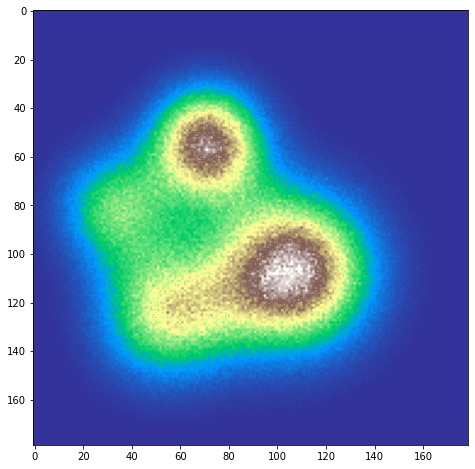

In [162]:
samples1 = np.random.multivariate_normal((6, 6), cov=np.eye(2)*2, size=4000000)
samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2)*1, size=1800000)
samples3 = np.random.multivariate_normal((4.5, 1.8), cov=np.eye(2), size=1100000)
samples4 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=2000000)
samples = np.concatenate((samples1, samples2, samples3, samples4))
bins = np.linspace(0, 10, 180)
bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins))[0] * 4

lmax = land.max()
land = (land / lmax)**2. * lmax

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain, vmin=0, vmax=4000)

making a few diagnostic slices

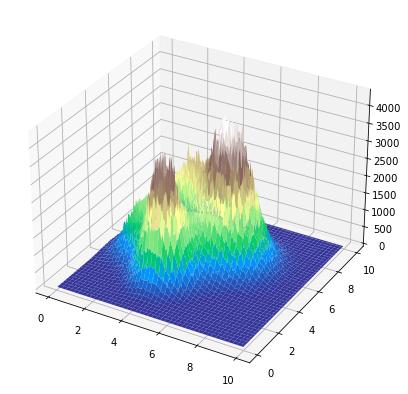

In [163]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111)

xx, yy = np.meshgrid(bcens, bcens)
zz = land.flatten()
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(7, 7))
ax.plot_surface(xx, yy, land, shade=True, cmap=plt.cm.terrain, )
# ax = plt.axes(projection='3d')
plt.show()

# Flow water down the hill

In [164]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

def null_edges(arr):
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [165]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [166]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def _calc_flows(self, vmap, outflow, cell):
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        return shifted_landslide.sum(axis=0)
    
    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        vmap += self._calc_flows(vmap, outflow, cell)
        return vmap
         
        
class RainFall(FlowRule):
    def __init__(self, rainfall=1, evap_rate=0., rainmap=None):
        """
        This is adds new rain water to the water canvas
        
        Perhaps later this will be a non uniform rainfall pattern, once heat and cold is introduced to 
        account for evaporation
        
        rainmap is the characteristic rainfall pattern
        net rainfall is the amplitude of the rainmap
        """
        self.layers = np.sort(("water",))
        self.key = "water"
               
        self.rainfall = rainfall
        self.evap_rate = evap_rate
        self.rainmap = rainmap
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        if self.rainmap is not None:
            water = self.rainmap * self.rainfall
        else:
            water = np.ones(shape=water_local.shape) * self.rainfall
        water -= self.evap_rate
        water[water < 1e-3] = 0.
            
        water_local += water
#         print(water_local)
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        

        
        
class Landslide(FlowRule):
    
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow = diffs * fractions * self.flow_factor # this is the outgoing amount
        
        height_local = self.calc_flows(cell, height_local, outflow)
        
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

# We are going to set up erosion in burst mode

A gaussian amount of rainfall, centered on the island

Each burst is simulated for a few hundred steps

## First let's map out the lay of rainfall distribution

In [169]:
tmp1 = np.random.multivariate_normal((60, 50), cov=np.eye(2)*400, size=10)
tmp2 = np.random.multivariate_normal((80, 100), cov=np.eye(2)*400, size=10)
tmp2 = np.random.multivariate_normal((100, 120), cov=np.eye(2)*300, size=10)
tmp3 = np.random.multivariate_normal((60, 130), cov=np.eye(2)*400, size=10)
tmp4 = np.random.multivariate_normal((130, 100), cov=np.eye(2)*400, size=10)
tmp5 = np.random.multivariate_normal((80, 80), cov=np.eye(2)*400, size=40)
rain_locs = np.vstack((tmp1, tmp2, tmp3, tmp4, tmp5))
np.random.shuffle(rain_locs)

In [197]:
bins = np.linspace(0, 180, 180)
rainbursts = []
for i, loc in enumerate(rain_locs):
    samples = np.random.multivariate_normal(loc, cov=np.eye(2)*30, size=1000)
    rainburst = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins), density=True)[0]
    rainbursts.append(rainburst * 1e6)

# = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins))[0] * 3


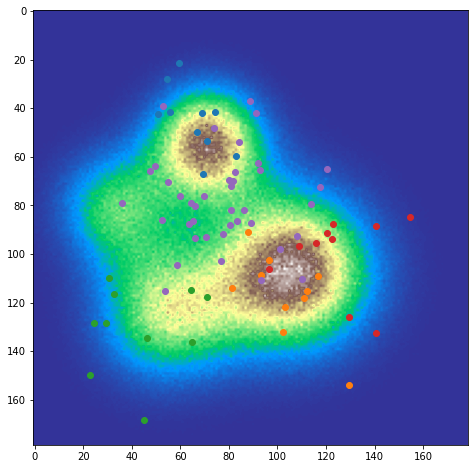

In [198]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(land, cmap=plt.cm.terrain, )
ax.scatter(tmp1[:, 0], tmp1[:, 1])
ax.scatter(tmp2[:, 0], tmp2[:, 1])
ax.scatter(tmp3[:, 0], tmp3[:, 1])
ax.scatter(tmp4[:, 0], tmp4[:, 1])
ax.scatter(tmp5[:, 0], tmp5[:, 1])

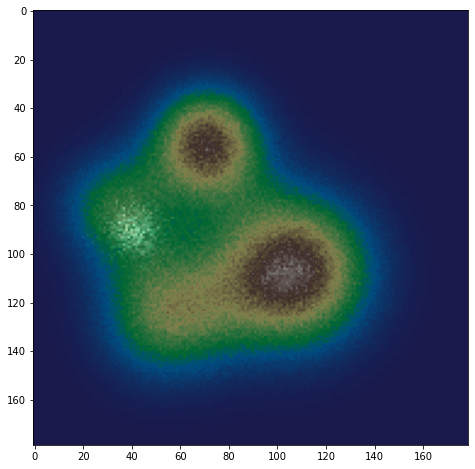

In [199]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(land, cmap=plt.cm.terrain, )
ax.imshow(rainbursts[0], alpha=0.5, cmap=plt.cm.gray)

In [200]:
   
class WaterGravelFlow(FlowRule):
    def __init__(self, altitude=10000, water_flow_rate=0.5, land_coerosion_rate=0.1,
                 drag_coeff=0.1, gravel_factor=4, flow_limit=10.):
        """
        This is a three component erosion model where water flows fast, and drags a fraction of the land with it
        Any land once dragged, will becone gravel, which erodes very easily
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        gravel_factor is the multiplier to the land coerosion rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        this is the lazy river approximation, where the velocity of water is negligible. Perhaps this is a mistake
        
        """
        self.layers = np.sort(("rock", "gravel" , "water"))
        self.wkey = "water"
        self.lkey = "rock"
        self.gkey = "gravel"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate
        self.drag_coeff = drag_coeff
        self.gravel_factor = gravel_factor
        self.altitude = altitude
                
    def evolve(self, cell):
        """
        It is interesting that the outflow direction is set by land + gravel,
        but the amount of drag possible is two
        """
#         np.set_printoptions(suppress=True)

        # these are the only canvases we are going to care about at all
        rock_local = cell.canvases[self.lkey]
        rock_shifted = cell.shifted_canvases[self.lkey]
        
        gravel_local = cell.canvases[self.gkey]
        gravel_shifted = cell.shifted_canvases[self.gkey]
        
        height_local = rock_local + gravel_local# + self.altitude
        height_shifted = rock_shifted + gravel_shifted# + self.altitude
        water_local = cell.canvases[self.wkey]
        water_shifted = cell.shifted_canvases[self.wkey]

        # 1) water flows along the gradient
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow_w = water_local * fractions * self.water_flow_rate
        water_local = self.calc_flows(water_local, outflow_w, cell)
        water_local = null_edges(water_local) # This models the part where water flows out of the canvas
        # no more land can outflow than there is difference
        # Due to the megaoutflow approximation, the water height can be VERY high, this means we need to rationalize
        # The amount of land drag possible to an actual sensible maximum
        
        # The rock must only eroded if there is no more gravel left... This is a really curious nonlinearity
        
        # 2) the gravel flows
        gflow_limit = np.sqrt(gravel_local) * self.drag_coeff * self.gravel_factor
        ii = np.where(gflow_limit > 0.1 * gravel_local)
        gflow_limit[ii] = 0.1 * gravel_local[ii]        
        gflow_limit = np.array([gflow_limit, ] * 4) / 4.
        outflow_g = outflow_w * self.land_coerosion_rate * self.gravel_factor
        ii = outflow_g > (gflow_limit)
        outflow_g[ii] = gflow_limit[ii]        
        gravel_local = self.calc_flows(gravel_local, outflow_g, cell)

        
        # 3) The rock erodes
        # we have to establish the local gravel coverage
        # The rock is eroded by the flow of water
        lflow_limit = np.sqrt(rock_local) * self.drag_coeff
        ii = np.where(lflow_limit > 0.1 * rock_local)
        lflow_limit[ii] = 0.1 * rock_local[ii]
        ii = np.where(gravel_local > 0)
        lflow_limit[ii] = 0. # This means the rock will never erode if its covered by gravel
        lflow_limit = np.array([lflow_limit, ] * 4) / 4.
#         lflow_limit = np.array([rock_local * self.drag_coeff,] * 4) / 4 # limit how much land can be dragged at each point
        
        # in megaoutflow, water can pile up really high, this must be regularized
        outflow_l = outflow_w * self.land_coerosion_rate
        ii = outflow_l > (lflow_limit)
        outflow_l[ii] = lflow_limit[ii]        
        
        rock_local -= outflow_l.sum(axis=0)    
        # The land is flown into gravel, not into land
        
        # 4) the gravel flows again to receive the erosion of the rock
        gravel_local += self._calc_flows(gravel_local, outflow_l, cell)

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: rock_local, self.gkey: gravel_local})
        
#         np.set_printoptions(suppress=False)
        return resdict    

In [201]:
rules = (
    WaterGravelFlow(land_coerosion_rate=0.5, water_flow_rate=0.9, drag_coeff=10, gravel_factor=),
)
wmap = np.zeros(shape=land.shape)
gmap = np.zeros(shape=land.shape)
initial_maps = {
    "rock": null_edges(land * 1.),
    "gravel": null_edges(land * 0.),
    "water": null_edges(wmap),
}

In [202]:
all_rock = []
all_gravel = []
all_waters = []
cs = CellSpace(initial_maps, rules)
cs.flow(1, savestep=1)
for i, wmap in enumerate(rainbursts[:30]):
    print(i)
    new_rock = copy.deepcopy(cs.maps["rock"][-1])
    new_gravel = copy.deepcopy(cs.maps["gravel"][-1])
    maps = {
        "rock": new_rock,
        "gravel": new_gravel,
        "water": wmap,
    }
    cs = CellSpace(maps, rules)
    cs.flow(400, savestep=100)
    all_rock.append(copy.deepcopy(cs.maps["rock"]))
    all_gravel.append(copy.deepcopy(cs.maps["gravel"]))
    all_waters.append(copy.deepcopy(cs.maps["water"]))

0 out of 0
0
0 out of 399
1 out of 399
2 out of 399
3 out of 399
4 out of 399
5 out of 399
6 out of 399
7 out of 399
8 out of 399
9 out of 399
10 out of 399
11 out of 399
12 out of 399
13 out of 399
14 out of 399
15 out of 399
16 out of 399
17 out of 399
18 out of 399
19 out of 399
20 out of 399
21 out of 399
22 out of 399
23 out of 399
24 out of 399
25 out of 399
26 out of 399
27 out of 399
28 out of 399


/tmp/ipykernel_4319/2369403438.py:50: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


29 out of 399
30 out of 399
31 out of 399
32 out of 399
33 out of 399
34 out of 399
35 out of 399
36 out of 399
37 out of 399
38 out of 399
39 out of 399
40 out of 399
41 out of 399
42 out of 399
43 out of 399
44 out of 399
45 out of 399
46 out of 399
47 out of 399
48 out of 399
49 out of 399
50 out of 399
51 out of 399
52 out of 399
53 out of 399
54 out of 399
55 out of 399
56 out of 399
57 out of 399
58 out of 399
59 out of 399
60 out of 399
61 out of 399
62 out of 399
63 out of 399
64 out of 399
65 out of 399
66 out of 399
67 out of 399
68 out of 399
69 out of 399
70 out of 399
71 out of 399
72 out of 399
73 out of 399
74 out of 399
75 out of 399
76 out of 399
77 out of 399
78 out of 399
79 out of 399
80 out of 399
81 out of 399
82 out of 399
83 out of 399
84 out of 399
85 out of 399
86 out of 399
87 out of 399
88 out of 399
89 out of 399
90 out of 399
91 out of 399
92 out of 399
93 out of 399
94 out of 399
95 out of 399
96 out of 399
97 out of 399
98 out of 399
99 out of 399
100 ou

192 out of 399
193 out of 399
194 out of 399
195 out of 399
196 out of 399
197 out of 399
198 out of 399
199 out of 399
200 out of 399
201 out of 399
202 out of 399
203 out of 399
204 out of 399
205 out of 399
206 out of 399
207 out of 399
208 out of 399
209 out of 399
210 out of 399
211 out of 399
212 out of 399
213 out of 399
214 out of 399
215 out of 399
216 out of 399
217 out of 399
218 out of 399
219 out of 399
220 out of 399
221 out of 399
222 out of 399
223 out of 399
224 out of 399
225 out of 399
226 out of 399
227 out of 399
228 out of 399
229 out of 399
230 out of 399
231 out of 399
232 out of 399
233 out of 399
234 out of 399
235 out of 399
236 out of 399
237 out of 399
238 out of 399
239 out of 399
240 out of 399
241 out of 399
242 out of 399
243 out of 399
244 out of 399
245 out of 399
246 out of 399
247 out of 399
248 out of 399
249 out of 399
250 out of 399
251 out of 399
252 out of 399
253 out of 399
254 out of 399
255 out of 399
256 out of 399
257 out of 399
258 out of

369 out of 399
370 out of 399
371 out of 399
372 out of 399
373 out of 399
374 out of 399
375 out of 399
376 out of 399
377 out of 399
378 out of 399
379 out of 399
380 out of 399
381 out of 399
382 out of 399
383 out of 399
384 out of 399
385 out of 399
386 out of 399
387 out of 399
388 out of 399
389 out of 399
390 out of 399
391 out of 399
392 out of 399
393 out of 399
394 out of 399
395 out of 399
396 out of 399
397 out of 399
398 out of 399
399 out of 399
3
0 out of 399
1 out of 399
2 out of 399
3 out of 399
4 out of 399
5 out of 399
6 out of 399
7 out of 399
8 out of 399
9 out of 399
10 out of 399
11 out of 399
12 out of 399
13 out of 399
14 out of 399
15 out of 399
16 out of 399
17 out of 399
18 out of 399
19 out of 399
20 out of 399
21 out of 399
22 out of 399
23 out of 399
24 out of 399
25 out of 399
26 out of 399
27 out of 399
28 out of 399
29 out of 399
30 out of 399
31 out of 399
32 out of 399
33 out of 399
34 out of 399
35 out of 399
36 out of 399
37 out of 399
38 out of 3

146 out of 399
147 out of 399
148 out of 399
149 out of 399
150 out of 399
151 out of 399
152 out of 399
153 out of 399
154 out of 399
155 out of 399
156 out of 399
157 out of 399
158 out of 399
159 out of 399
160 out of 399
161 out of 399
162 out of 399
163 out of 399
164 out of 399
165 out of 399
166 out of 399
167 out of 399
168 out of 399
169 out of 399
170 out of 399
171 out of 399
172 out of 399
173 out of 399
174 out of 399
175 out of 399
176 out of 399
177 out of 399
178 out of 399
179 out of 399
180 out of 399
181 out of 399
182 out of 399
183 out of 399
184 out of 399
185 out of 399
186 out of 399
187 out of 399
188 out of 399
189 out of 399
190 out of 399
191 out of 399
192 out of 399
193 out of 399
194 out of 399
195 out of 399
196 out of 399
197 out of 399
198 out of 399
199 out of 399
200 out of 399
201 out of 399
202 out of 399
203 out of 399
204 out of 399
205 out of 399
206 out of 399
207 out of 399
208 out of 399
209 out of 399
210 out of 399
211 out of 399
212 out of

323 out of 399
324 out of 399
325 out of 399
326 out of 399
327 out of 399
328 out of 399
329 out of 399
330 out of 399
331 out of 399
332 out of 399
333 out of 399
334 out of 399
335 out of 399
336 out of 399
337 out of 399
338 out of 399
339 out of 399
340 out of 399
341 out of 399
342 out of 399
343 out of 399
344 out of 399
345 out of 399
346 out of 399
347 out of 399
348 out of 399
349 out of 399
350 out of 399
351 out of 399
352 out of 399
353 out of 399
354 out of 399
355 out of 399
356 out of 399
357 out of 399
358 out of 399
359 out of 399
360 out of 399
361 out of 399
362 out of 399
363 out of 399
364 out of 399
365 out of 399
366 out of 399
367 out of 399
368 out of 399
369 out of 399
370 out of 399
371 out of 399
372 out of 399
373 out of 399
374 out of 399
375 out of 399
376 out of 399
377 out of 399
378 out of 399
379 out of 399
380 out of 399
381 out of 399
382 out of 399
383 out of 399
384 out of 399
385 out of 399
386 out of 399
387 out of 399
388 out of 399
389 out of

115 out of 399
116 out of 399
117 out of 399
118 out of 399
119 out of 399
120 out of 399
121 out of 399
122 out of 399
123 out of 399
124 out of 399
125 out of 399
126 out of 399
127 out of 399
128 out of 399
129 out of 399
130 out of 399
131 out of 399
132 out of 399
133 out of 399
134 out of 399
135 out of 399
136 out of 399
137 out of 399
138 out of 399
139 out of 399
140 out of 399
141 out of 399
142 out of 399
143 out of 399
144 out of 399
145 out of 399
146 out of 399
147 out of 399
148 out of 399
149 out of 399
150 out of 399
151 out of 399
152 out of 399
153 out of 399
154 out of 399
155 out of 399
156 out of 399
157 out of 399
158 out of 399
159 out of 399
160 out of 399
161 out of 399
162 out of 399
163 out of 399
164 out of 399
165 out of 399
166 out of 399
167 out of 399
168 out of 399
169 out of 399
170 out of 399
171 out of 399
172 out of 399
173 out of 399
174 out of 399
175 out of 399
176 out of 399
177 out of 399
178 out of 399
179 out of 399
180 out of 399
181 out of

299 out of 399
300 out of 399
301 out of 399
302 out of 399
303 out of 399
304 out of 399
305 out of 399
306 out of 399
307 out of 399
308 out of 399
309 out of 399
310 out of 399
311 out of 399
312 out of 399
313 out of 399
314 out of 399
315 out of 399
316 out of 399
317 out of 399
318 out of 399
319 out of 399
320 out of 399
321 out of 399
322 out of 399
323 out of 399
324 out of 399
325 out of 399
326 out of 399
327 out of 399
328 out of 399
329 out of 399
330 out of 399
331 out of 399
332 out of 399
333 out of 399
334 out of 399
335 out of 399
336 out of 399
337 out of 399
338 out of 399
339 out of 399
340 out of 399
341 out of 399
342 out of 399
343 out of 399
344 out of 399
345 out of 399
346 out of 399
347 out of 399
348 out of 399
349 out of 399
350 out of 399
351 out of 399
352 out of 399
353 out of 399
354 out of 399
355 out of 399
356 out of 399
357 out of 399
358 out of 399
359 out of 399
360 out of 399
361 out of 399
362 out of 399
363 out of 399
364 out of 399
365 out of

82 out of 399
83 out of 399
84 out of 399
85 out of 399
86 out of 399
87 out of 399
88 out of 399
89 out of 399
90 out of 399
91 out of 399
92 out of 399
93 out of 399
94 out of 399
95 out of 399
96 out of 399
97 out of 399
98 out of 399
99 out of 399
100 out of 399
101 out of 399
102 out of 399
103 out of 399
104 out of 399
105 out of 399
106 out of 399
107 out of 399
108 out of 399
109 out of 399
110 out of 399
111 out of 399
112 out of 399
113 out of 399
114 out of 399
115 out of 399
116 out of 399
117 out of 399
118 out of 399
119 out of 399
120 out of 399
121 out of 399
122 out of 399
123 out of 399
124 out of 399
125 out of 399
126 out of 399
127 out of 399
128 out of 399
129 out of 399
130 out of 399
131 out of 399
132 out of 399
133 out of 399
134 out of 399
135 out of 399
136 out of 399
137 out of 399
138 out of 399
139 out of 399
140 out of 399
141 out of 399
142 out of 399
143 out of 399
144 out of 399
145 out of 399
146 out of 399
147 out of 399
148 out of 399
149 out of 39

242 out of 399
243 out of 399
244 out of 399
245 out of 399
246 out of 399
247 out of 399
248 out of 399
249 out of 399
250 out of 399
251 out of 399
252 out of 399
253 out of 399
254 out of 399
255 out of 399
256 out of 399
257 out of 399
258 out of 399
259 out of 399
260 out of 399
261 out of 399
262 out of 399
263 out of 399
264 out of 399
265 out of 399
266 out of 399
267 out of 399
268 out of 399
269 out of 399
270 out of 399
271 out of 399
272 out of 399
273 out of 399
274 out of 399
275 out of 399
276 out of 399
277 out of 399
278 out of 399
279 out of 399
280 out of 399
281 out of 399
282 out of 399
283 out of 399
284 out of 399
285 out of 399
286 out of 399
287 out of 399
288 out of 399
289 out of 399
290 out of 399
291 out of 399
292 out of 399
293 out of 399
294 out of 399
295 out of 399
296 out of 399
297 out of 399
298 out of 399
299 out of 399
300 out of 399
301 out of 399
302 out of 399
303 out of 399
304 out of 399
305 out of 399
306 out of 399
307 out of 399
308 out of

13 out of 399
14 out of 399
15 out of 399
16 out of 399
17 out of 399
18 out of 399
19 out of 399
20 out of 399
21 out of 399
22 out of 399
23 out of 399
24 out of 399
25 out of 399
26 out of 399
27 out of 399
28 out of 399
29 out of 399
30 out of 399
31 out of 399
32 out of 399
33 out of 399
34 out of 399
35 out of 399
36 out of 399
37 out of 399
38 out of 399
39 out of 399
40 out of 399
41 out of 399
42 out of 399
43 out of 399
44 out of 399
45 out of 399
46 out of 399
47 out of 399
48 out of 399
49 out of 399
50 out of 399
51 out of 399
52 out of 399
53 out of 399
54 out of 399
55 out of 399
56 out of 399
57 out of 399
58 out of 399
59 out of 399
60 out of 399
61 out of 399
62 out of 399
63 out of 399
64 out of 399
65 out of 399
66 out of 399
67 out of 399
68 out of 399
69 out of 399
70 out of 399
71 out of 399
72 out of 399
73 out of 399
74 out of 399
75 out of 399
76 out of 399
77 out of 399
78 out of 399
79 out of 399
80 out of 399
81 out of 399
82 out of 399
83 out of 399
84 out

174 out of 399
175 out of 399
176 out of 399
177 out of 399
178 out of 399
179 out of 399
180 out of 399
181 out of 399
182 out of 399
183 out of 399
184 out of 399
185 out of 399
186 out of 399
187 out of 399
188 out of 399
189 out of 399
190 out of 399
191 out of 399
192 out of 399
193 out of 399
194 out of 399
195 out of 399
196 out of 399
197 out of 399
198 out of 399
199 out of 399
200 out of 399
201 out of 399
202 out of 399
203 out of 399
204 out of 399
205 out of 399
206 out of 399
207 out of 399
208 out of 399
209 out of 399
210 out of 399
211 out of 399
212 out of 399
213 out of 399
214 out of 399
215 out of 399
216 out of 399
217 out of 399
218 out of 399
219 out of 399
220 out of 399
221 out of 399
222 out of 399
223 out of 399
224 out of 399
225 out of 399
226 out of 399
227 out of 399
228 out of 399
229 out of 399
230 out of 399
231 out of 399
232 out of 399
233 out of 399
234 out of 399
235 out of 399
236 out of 399
237 out of 399
238 out of 399
239 out of 399
240 out of

330 out of 399
331 out of 399
332 out of 399
333 out of 399
334 out of 399
335 out of 399
336 out of 399
337 out of 399
338 out of 399
339 out of 399
340 out of 399
341 out of 399
342 out of 399
343 out of 399
344 out of 399
345 out of 399
346 out of 399
347 out of 399
348 out of 399
349 out of 399
350 out of 399
351 out of 399
352 out of 399
353 out of 399
354 out of 399
355 out of 399
356 out of 399
357 out of 399
358 out of 399
359 out of 399
360 out of 399
361 out of 399
362 out of 399
363 out of 399
364 out of 399
365 out of 399
366 out of 399
367 out of 399
368 out of 399
369 out of 399
370 out of 399
371 out of 399
372 out of 399
373 out of 399
374 out of 399
375 out of 399
376 out of 399
377 out of 399
378 out of 399
379 out of 399
380 out of 399
381 out of 399
382 out of 399
383 out of 399
384 out of 399
385 out of 399
386 out of 399
387 out of 399
388 out of 399
389 out of 399
390 out of 399
391 out of 399
392 out of 399
393 out of 399
394 out of 399
395 out of 399
396 out of

91 out of 399
92 out of 399
93 out of 399
94 out of 399
95 out of 399
96 out of 399
97 out of 399
98 out of 399
99 out of 399
100 out of 399
101 out of 399
102 out of 399
103 out of 399
104 out of 399
105 out of 399
106 out of 399
107 out of 399
108 out of 399
109 out of 399
110 out of 399
111 out of 399
112 out of 399
113 out of 399
114 out of 399
115 out of 399
116 out of 399
117 out of 399
118 out of 399
119 out of 399
120 out of 399
121 out of 399
122 out of 399
123 out of 399
124 out of 399
125 out of 399
126 out of 399
127 out of 399
128 out of 399
129 out of 399
130 out of 399
131 out of 399
132 out of 399
133 out of 399
134 out of 399
135 out of 399
136 out of 399
137 out of 399
138 out of 399
139 out of 399
140 out of 399
141 out of 399
142 out of 399
143 out of 399
144 out of 399
145 out of 399
146 out of 399
147 out of 399
148 out of 399
149 out of 399
150 out of 399
151 out of 399
152 out of 399
153 out of 399
154 out of 399
155 out of 399
156 out of 399
157 out of 399
158 

275 out of 399
276 out of 399
277 out of 399
278 out of 399
279 out of 399
280 out of 399
281 out of 399
282 out of 399
283 out of 399
284 out of 399
285 out of 399
286 out of 399
287 out of 399
288 out of 399
289 out of 399
290 out of 399
291 out of 399
292 out of 399
293 out of 399
294 out of 399
295 out of 399
296 out of 399
297 out of 399
298 out of 399
299 out of 399
300 out of 399
301 out of 399
302 out of 399
303 out of 399
304 out of 399
305 out of 399
306 out of 399
307 out of 399
308 out of 399
309 out of 399
310 out of 399
311 out of 399
312 out of 399
313 out of 399
314 out of 399
315 out of 399
316 out of 399
317 out of 399
318 out of 399
319 out of 399
320 out of 399
321 out of 399
322 out of 399
323 out of 399
324 out of 399
325 out of 399
326 out of 399
327 out of 399
328 out of 399
329 out of 399
330 out of 399
331 out of 399
332 out of 399
333 out of 399
334 out of 399
335 out of 399
336 out of 399
337 out of 399
338 out of 399
339 out of 399
340 out of 399
341 out of

52 out of 399
53 out of 399
54 out of 399
55 out of 399
56 out of 399
57 out of 399
58 out of 399
59 out of 399
60 out of 399
61 out of 399
62 out of 399
63 out of 399
64 out of 399
65 out of 399
66 out of 399
67 out of 399
68 out of 399
69 out of 399
70 out of 399
71 out of 399
72 out of 399
73 out of 399
74 out of 399
75 out of 399
76 out of 399
77 out of 399
78 out of 399
79 out of 399
80 out of 399
81 out of 399
82 out of 399
83 out of 399
84 out of 399
85 out of 399
86 out of 399
87 out of 399
88 out of 399
89 out of 399
90 out of 399
91 out of 399
92 out of 399
93 out of 399
94 out of 399
95 out of 399
96 out of 399
97 out of 399
98 out of 399
99 out of 399
100 out of 399
101 out of 399
102 out of 399
103 out of 399
104 out of 399
105 out of 399
106 out of 399
107 out of 399
108 out of 399
109 out of 399
110 out of 399
111 out of 399
112 out of 399
113 out of 399
114 out of 399
115 out of 399
116 out of 399
117 out of 399
118 out of 399
119 out of 399
120 out of 399
121 out of 39

213 out of 399
214 out of 399
215 out of 399
216 out of 399
217 out of 399
218 out of 399
219 out of 399
220 out of 399
221 out of 399
222 out of 399
223 out of 399
224 out of 399
225 out of 399
226 out of 399
227 out of 399
228 out of 399
229 out of 399
230 out of 399
231 out of 399
232 out of 399
233 out of 399
234 out of 399
235 out of 399
236 out of 399
237 out of 399
238 out of 399
239 out of 399
240 out of 399
241 out of 399
242 out of 399
243 out of 399
244 out of 399
245 out of 399
246 out of 399
247 out of 399
248 out of 399
249 out of 399
250 out of 399
251 out of 399
252 out of 399
253 out of 399
254 out of 399
255 out of 399
256 out of 399
257 out of 399
258 out of 399
259 out of 399
260 out of 399
261 out of 399
262 out of 399
263 out of 399
264 out of 399
265 out of 399
266 out of 399
267 out of 399
268 out of 399
269 out of 399
270 out of 399
271 out of 399
272 out of 399
273 out of 399
274 out of 399
275 out of 399
276 out of 399
277 out of 399
278 out of 399
279 out of

371 out of 399
372 out of 399
373 out of 399
374 out of 399
375 out of 399
376 out of 399
377 out of 399
378 out of 399
379 out of 399
380 out of 399
381 out of 399
382 out of 399
383 out of 399
384 out of 399
385 out of 399
386 out of 399
387 out of 399
388 out of 399
389 out of 399
390 out of 399
391 out of 399
392 out of 399
393 out of 399
394 out of 399
395 out of 399
396 out of 399
397 out of 399
398 out of 399
399 out of 399
23
0 out of 399
1 out of 399
2 out of 399
3 out of 399
4 out of 399
5 out of 399
6 out of 399
7 out of 399
8 out of 399
9 out of 399
10 out of 399
11 out of 399
12 out of 399
13 out of 399
14 out of 399
15 out of 399
16 out of 399
17 out of 399
18 out of 399
19 out of 399
20 out of 399
21 out of 399
22 out of 399
23 out of 399
24 out of 399
25 out of 399
26 out of 399
27 out of 399
28 out of 399
29 out of 399
30 out of 399
31 out of 399
32 out of 399
33 out of 399
34 out of 399
35 out of 399
36 out of 399
37 out of 399
38 out of 399
39 out of 399
40 out of 39

161 out of 399
162 out of 399
163 out of 399
164 out of 399
165 out of 399
166 out of 399
167 out of 399
168 out of 399
169 out of 399
170 out of 399
171 out of 399
172 out of 399
173 out of 399
174 out of 399
175 out of 399
176 out of 399
177 out of 399
178 out of 399
179 out of 399
180 out of 399
181 out of 399
182 out of 399
183 out of 399
184 out of 399
185 out of 399
186 out of 399
187 out of 399
188 out of 399
189 out of 399
190 out of 399
191 out of 399
192 out of 399
193 out of 399
194 out of 399
195 out of 399
196 out of 399
197 out of 399
198 out of 399
199 out of 399
200 out of 399
201 out of 399
202 out of 399
203 out of 399
204 out of 399
205 out of 399
206 out of 399
207 out of 399
208 out of 399
209 out of 399
210 out of 399
211 out of 399
212 out of 399
213 out of 399
214 out of 399
215 out of 399
216 out of 399
217 out of 399
218 out of 399
219 out of 399
220 out of 399
221 out of 399
222 out of 399
223 out of 399
224 out of 399
225 out of 399
226 out of 399
227 out of

326 out of 399
327 out of 399
328 out of 399
329 out of 399
330 out of 399
331 out of 399
332 out of 399
333 out of 399
334 out of 399
335 out of 399
336 out of 399
337 out of 399
338 out of 399
339 out of 399
340 out of 399
341 out of 399
342 out of 399
343 out of 399
344 out of 399
345 out of 399
346 out of 399
347 out of 399
348 out of 399
349 out of 399
350 out of 399
351 out of 399
352 out of 399
353 out of 399
354 out of 399
355 out of 399
356 out of 399
357 out of 399
358 out of 399
359 out of 399
360 out of 399
361 out of 399
362 out of 399
363 out of 399
364 out of 399
365 out of 399
366 out of 399
367 out of 399
368 out of 399
369 out of 399
370 out of 399
371 out of 399
372 out of 399
373 out of 399
374 out of 399
375 out of 399
376 out of 399
377 out of 399
378 out of 399
379 out of 399
380 out of 399
381 out of 399
382 out of 399
383 out of 399
384 out of 399
385 out of 399
386 out of 399
387 out of 399
388 out of 399
389 out of 399
390 out of 399
391 out of 399
392 out of

86 out of 399
87 out of 399
88 out of 399
89 out of 399
90 out of 399
91 out of 399
92 out of 399
93 out of 399
94 out of 399
95 out of 399
96 out of 399
97 out of 399
98 out of 399
99 out of 399
100 out of 399
101 out of 399
102 out of 399
103 out of 399
104 out of 399
105 out of 399
106 out of 399
107 out of 399
108 out of 399
109 out of 399
110 out of 399
111 out of 399
112 out of 399
113 out of 399
114 out of 399
115 out of 399
116 out of 399
117 out of 399
118 out of 399
119 out of 399
120 out of 399
121 out of 399
122 out of 399
123 out of 399
124 out of 399
125 out of 399
126 out of 399
127 out of 399
128 out of 399
129 out of 399
130 out of 399
131 out of 399
132 out of 399
133 out of 399
134 out of 399
135 out of 399
136 out of 399
137 out of 399
138 out of 399
139 out of 399
140 out of 399
141 out of 399
142 out of 399
143 out of 399
144 out of 399
145 out of 399
146 out of 399
147 out of 399
148 out of 399
149 out of 399
150 out of 399
151 out of 399
152 out of 399
153 out o

250 out of 399
251 out of 399
252 out of 399
253 out of 399
254 out of 399
255 out of 399
256 out of 399
257 out of 399
258 out of 399
259 out of 399
260 out of 399
261 out of 399
262 out of 399
263 out of 399
264 out of 399
265 out of 399
266 out of 399
267 out of 399
268 out of 399
269 out of 399
270 out of 399
271 out of 399
272 out of 399
273 out of 399
274 out of 399
275 out of 399
276 out of 399
277 out of 399
278 out of 399
279 out of 399
280 out of 399
281 out of 399
282 out of 399
283 out of 399
284 out of 399
285 out of 399
286 out of 399
287 out of 399
288 out of 399
289 out of 399
290 out of 399
291 out of 399
292 out of 399
293 out of 399
294 out of 399
295 out of 399
296 out of 399
297 out of 399
298 out of 399
299 out of 399
300 out of 399
301 out of 399
302 out of 399
303 out of 399
304 out of 399
305 out of 399
306 out of 399
307 out of 399
308 out of 399
309 out of 399
310 out of 399
311 out of 399
312 out of 399
313 out of 399
314 out of 399
315 out of 399
316 out of

In [203]:
rock = np.concatenate(all_rock)
gravel = np.concatenate(all_gravel)
waters = np.concatenate(all_waters)

In [204]:
# for j in np.arange(10)[:10]:
# #     for i in (0, 4):
# # j = 0
#     for i in np.arange(5):
#         fig = plt.figure(figsize=(12, 12))
#         ax = fig.add_subplot(111)
#         title = "Run " + str(j) + " save step " + str(i)
#         ax.set_title(title)
# #         ax.imshow(all_gravel[j][i] + all_rock[j][i], cmap=plt.cm.terrain, )
#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#         alphas = all_waters[j][i] / 100
#         alphas[alphas > 1] = 1
#         ax.imshow(all_waters[j][i], cmap=plt.cm.gray_r, vmin=0, vmax=100, alpha=alphas)

In [205]:
# len(all_gravel

/tmp/ipykernel_4319/652049870.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


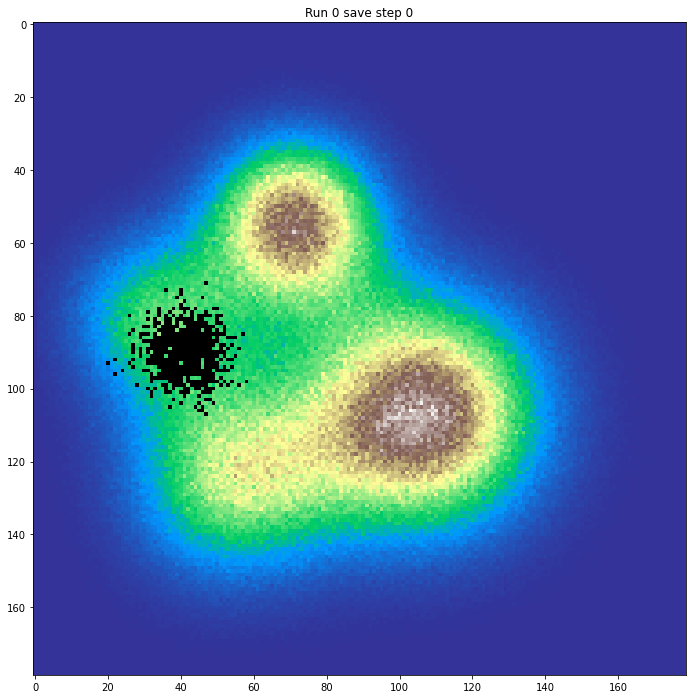

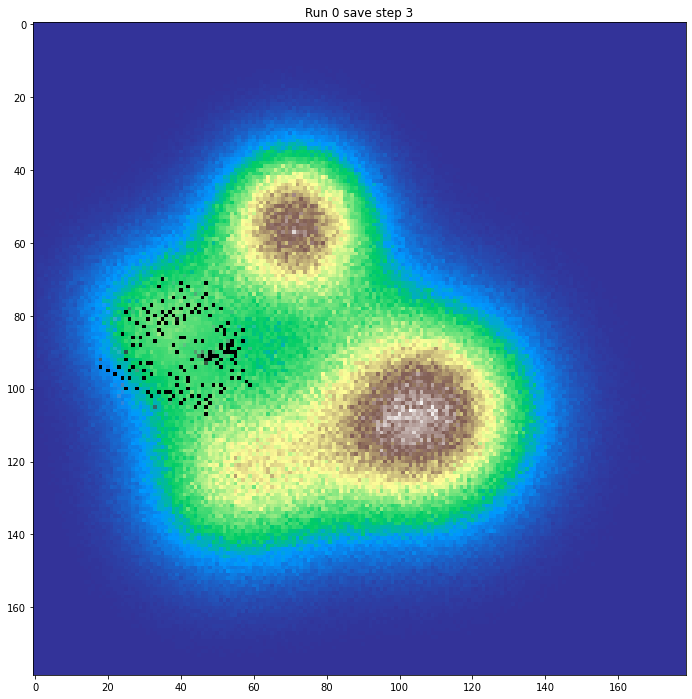

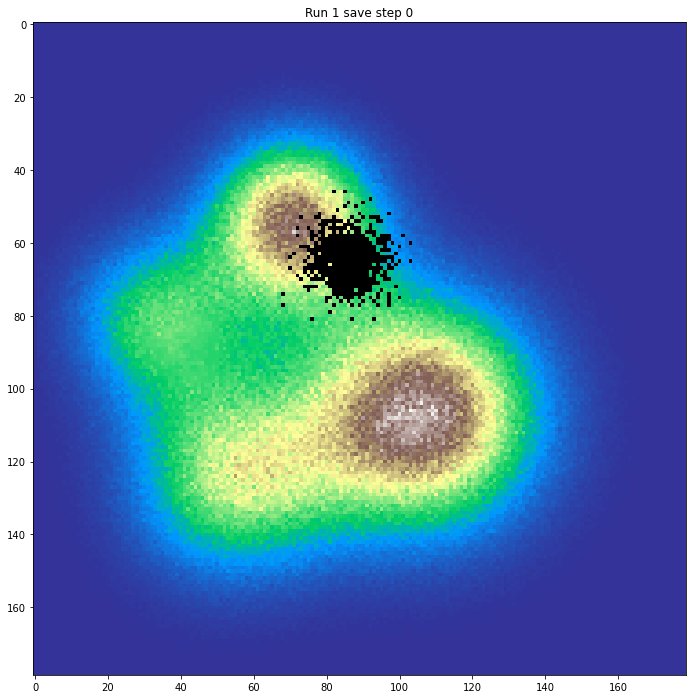

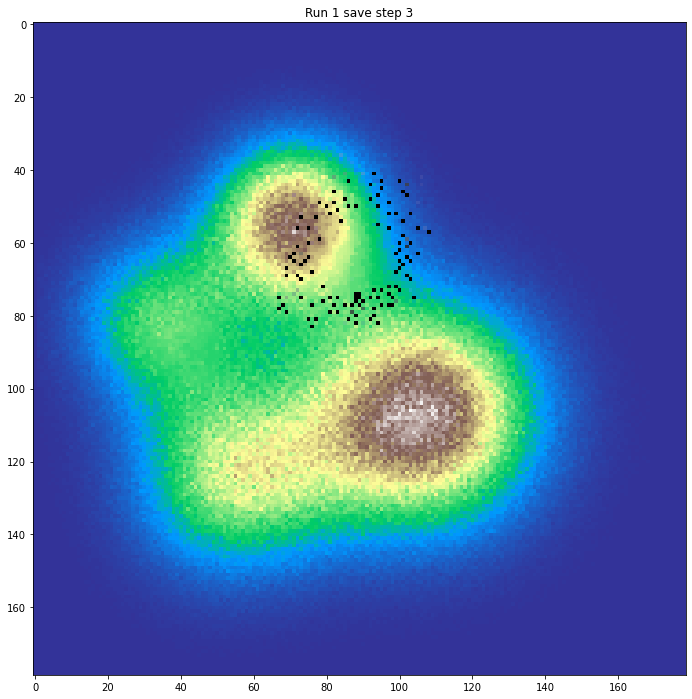

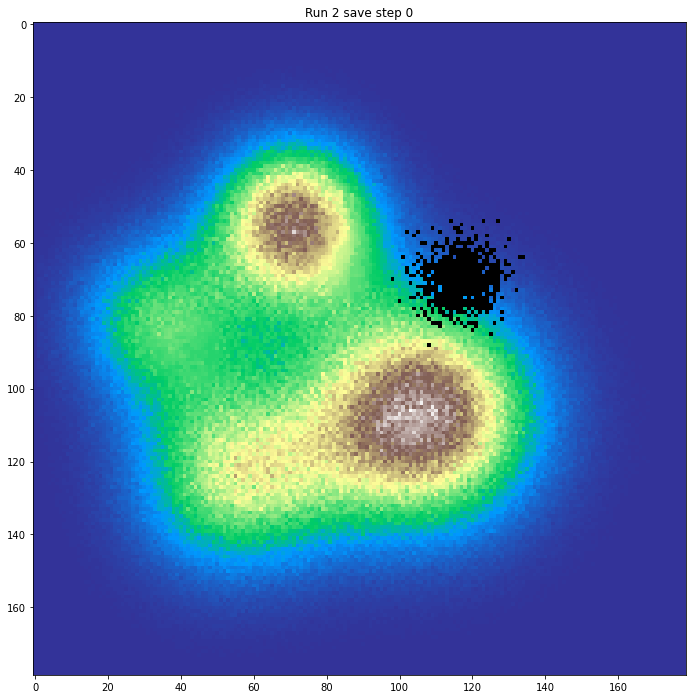

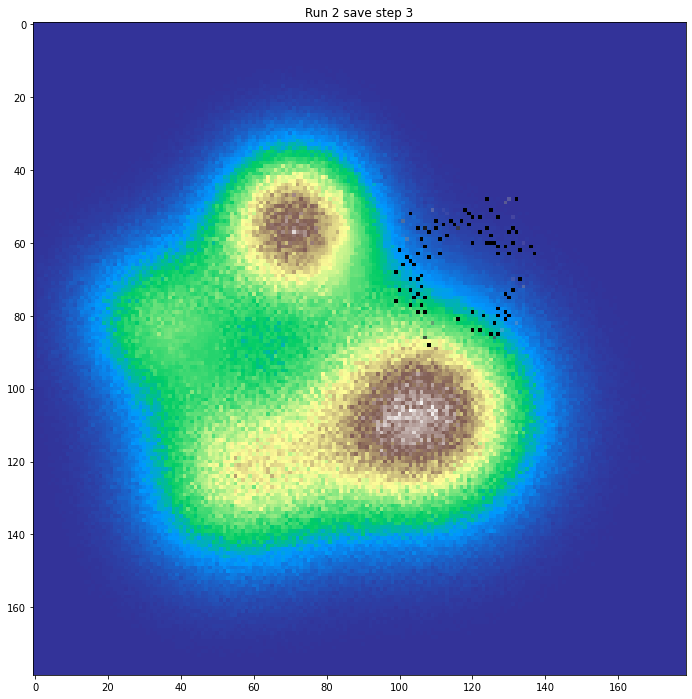

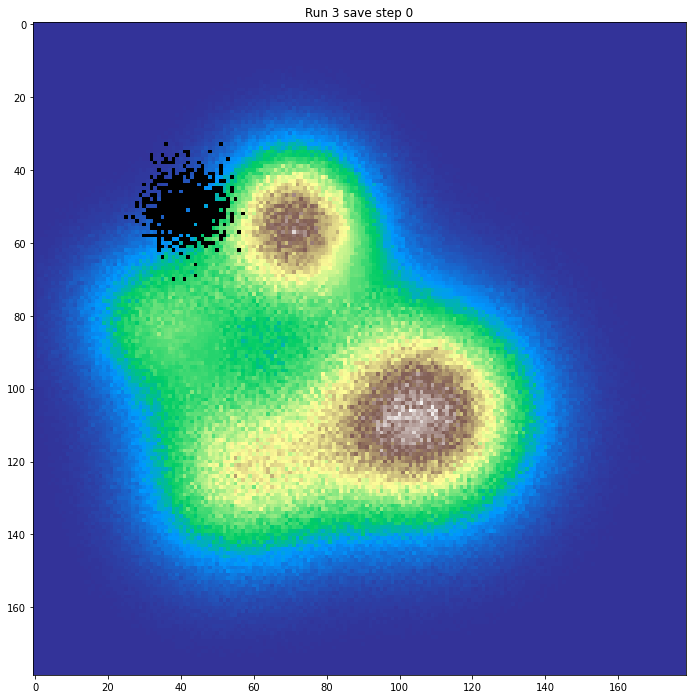

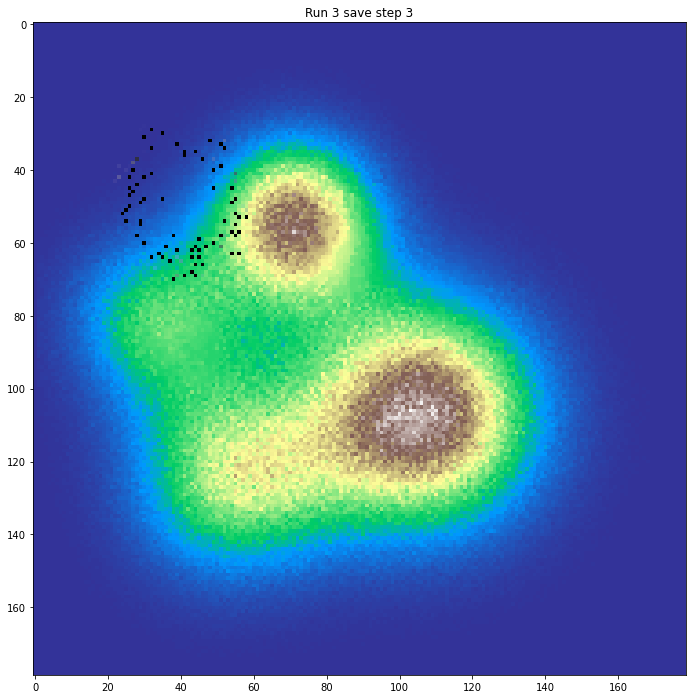

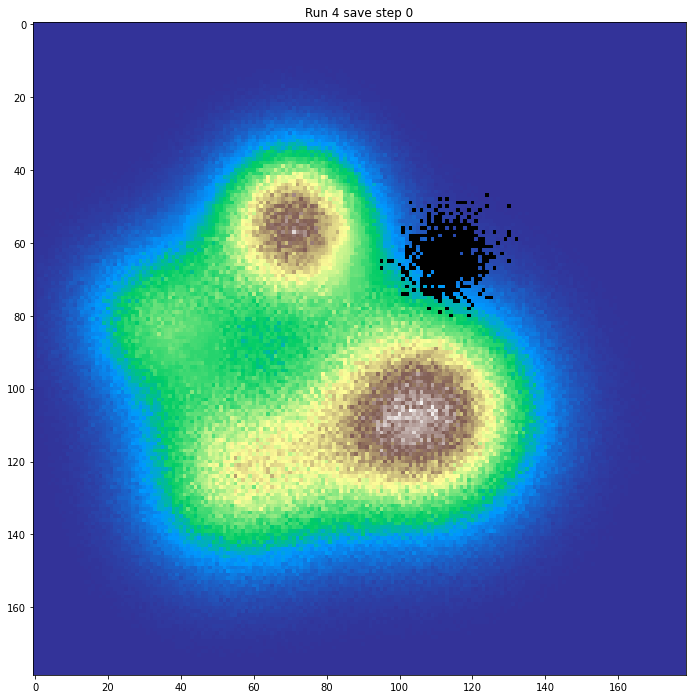

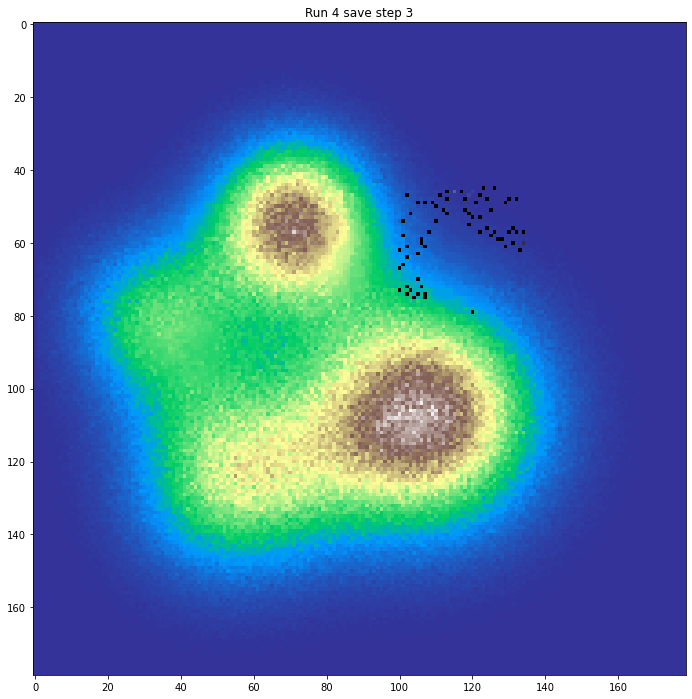

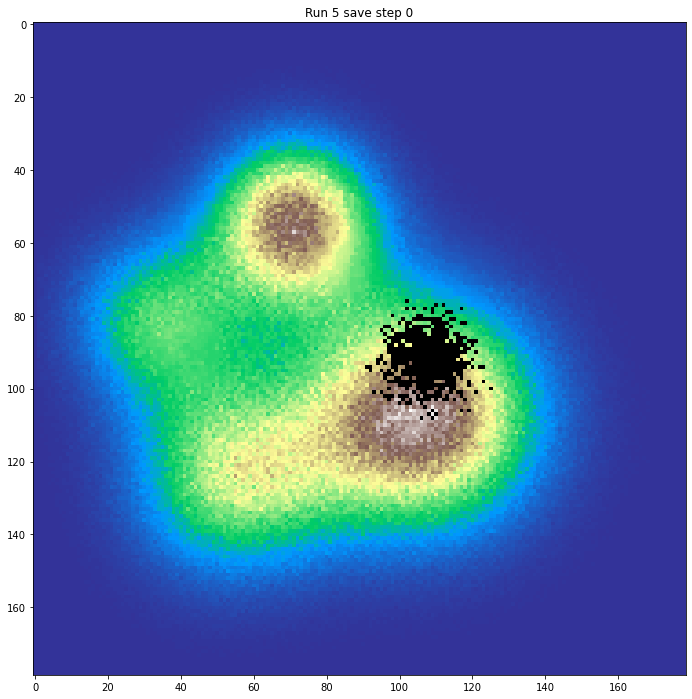

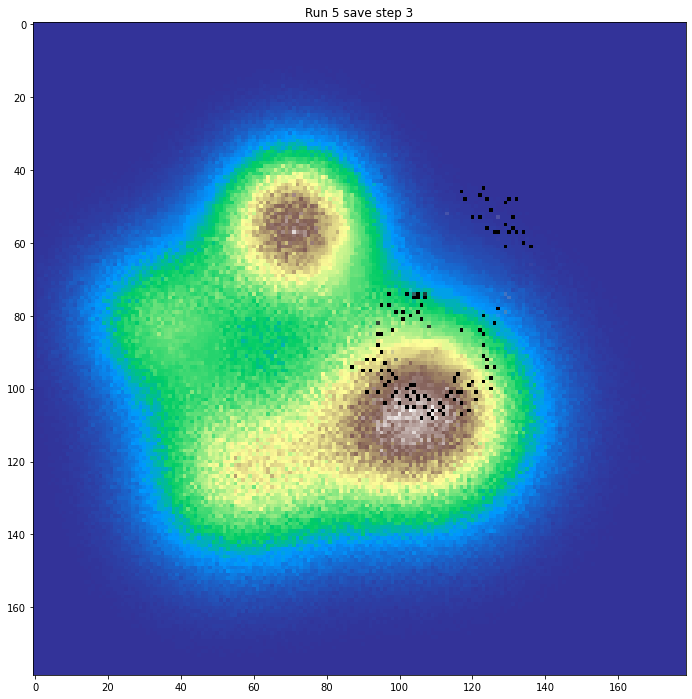

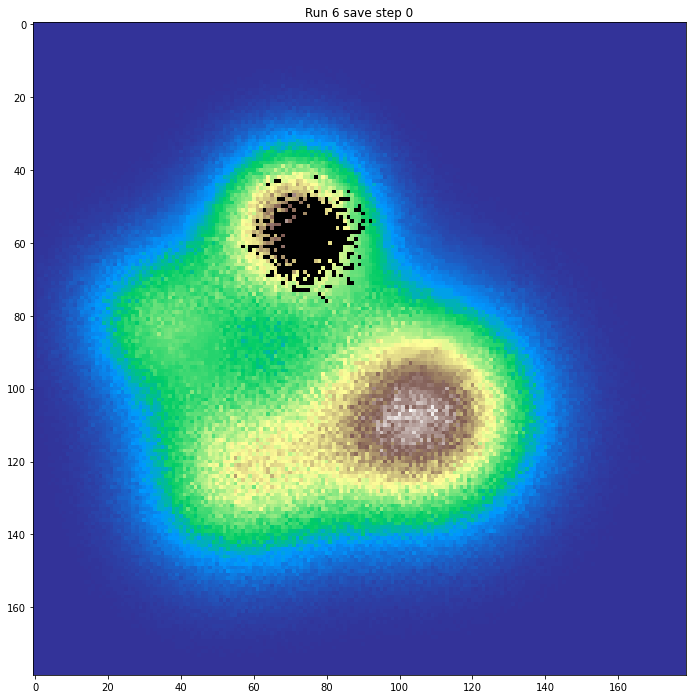

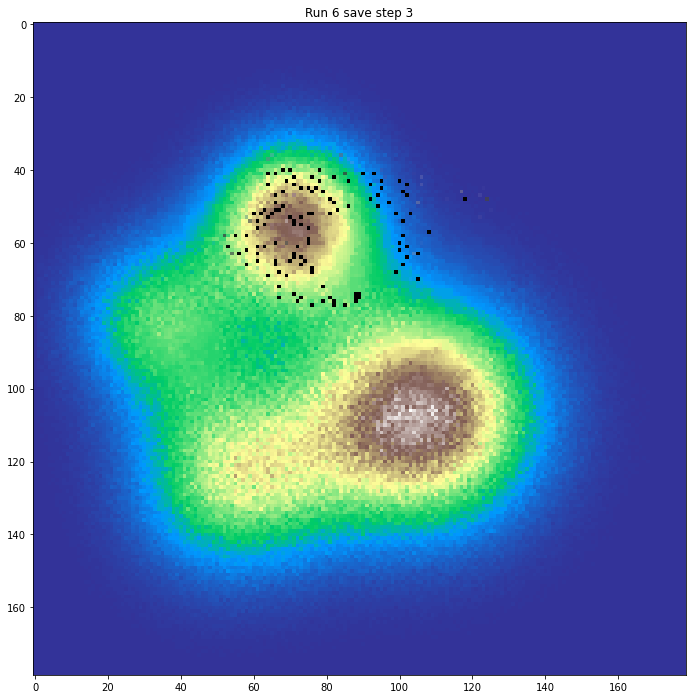

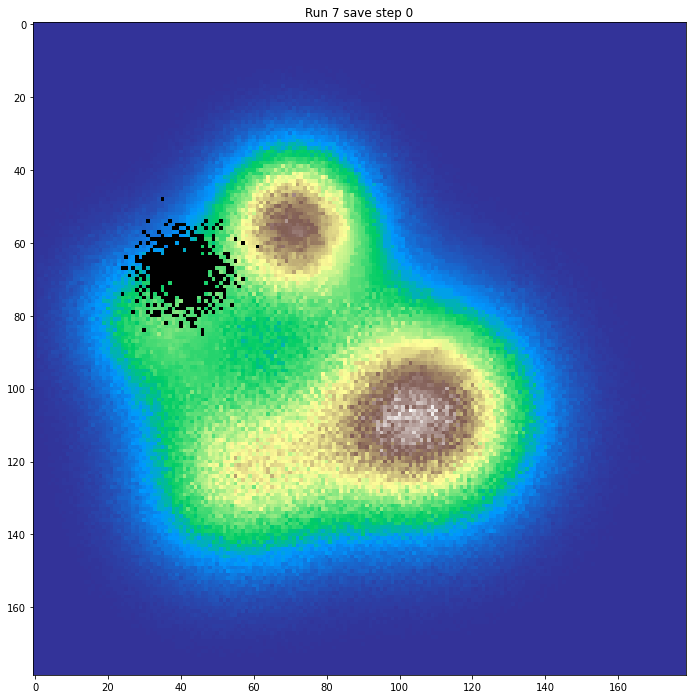

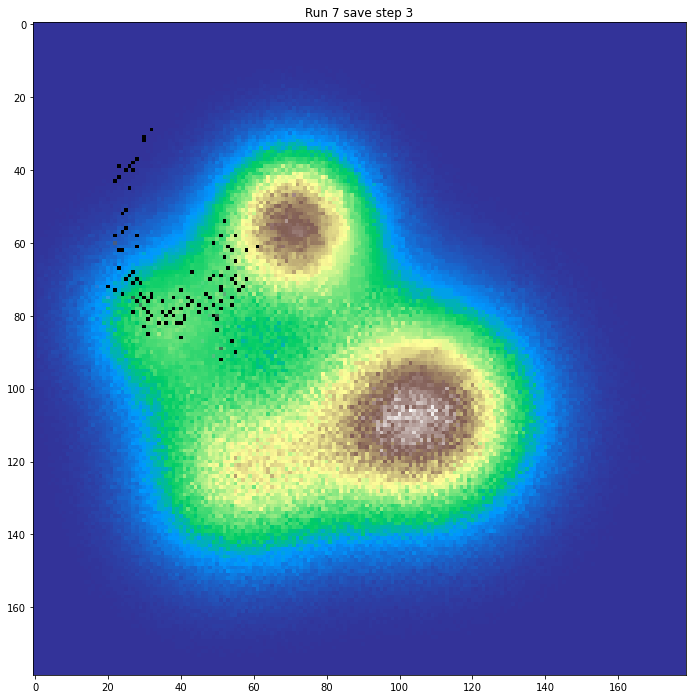

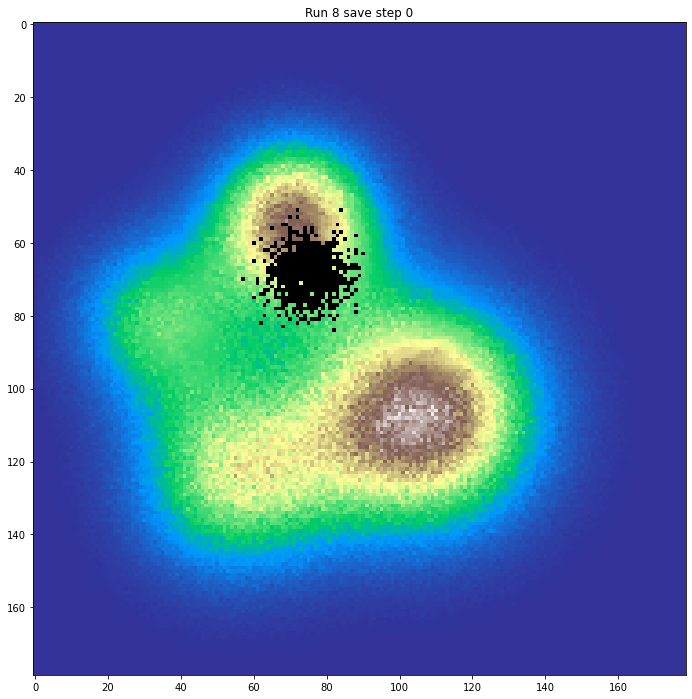

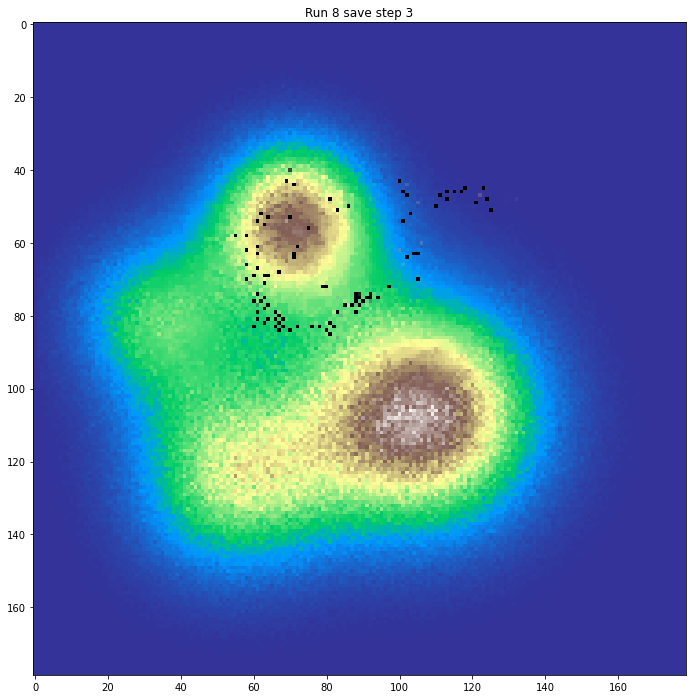

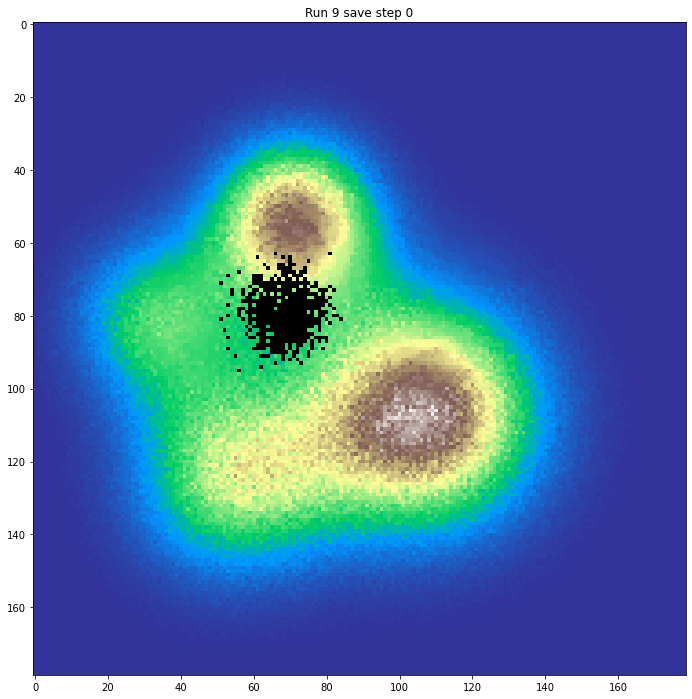

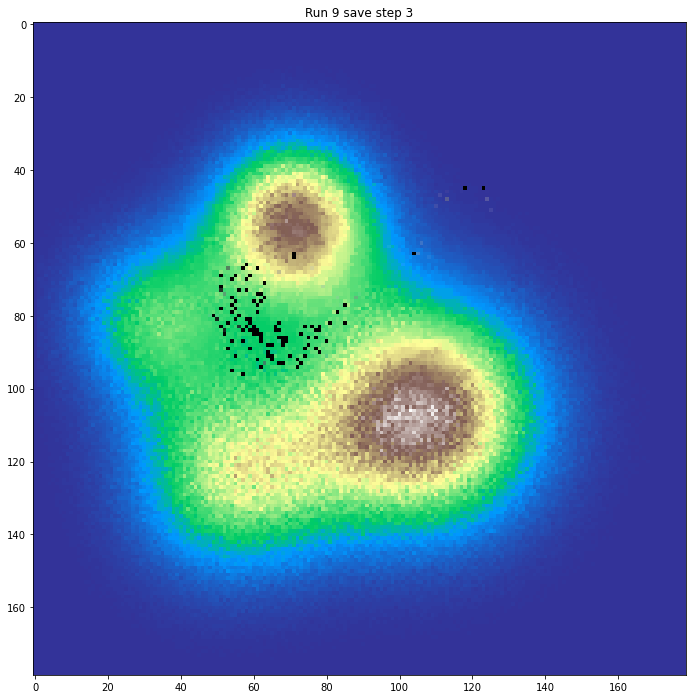

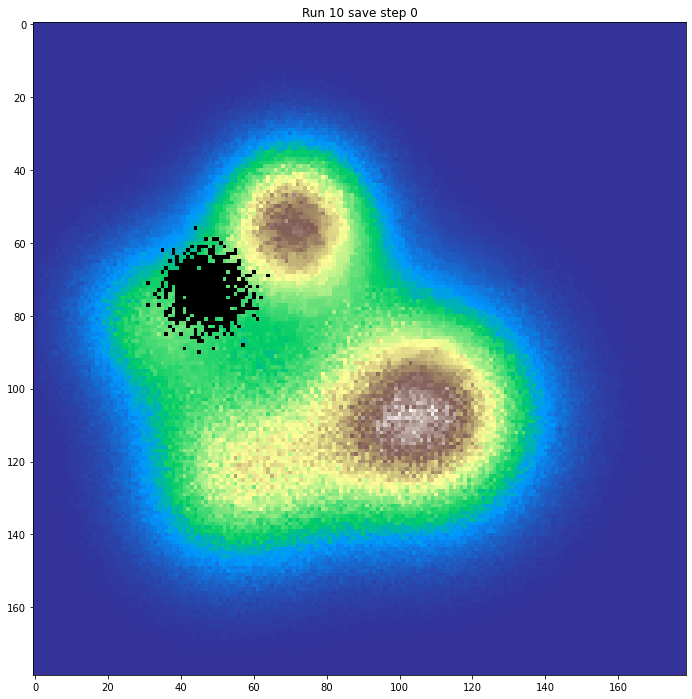

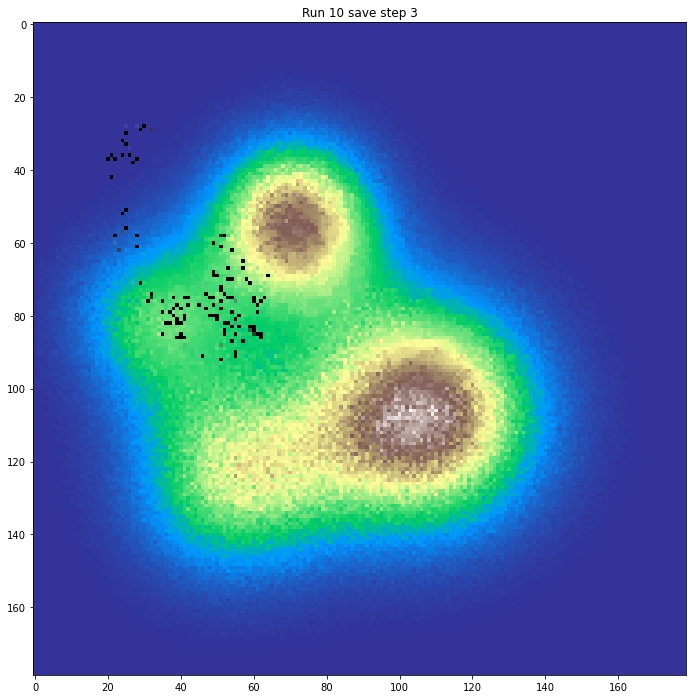

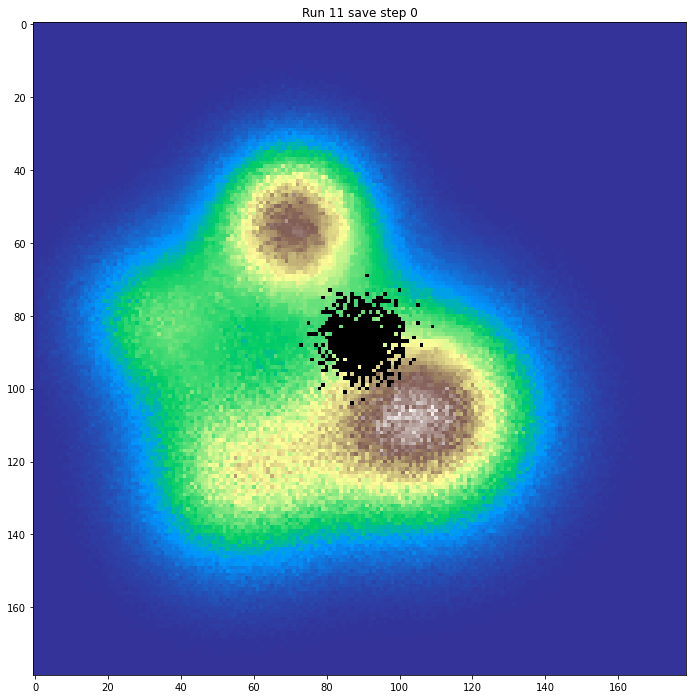

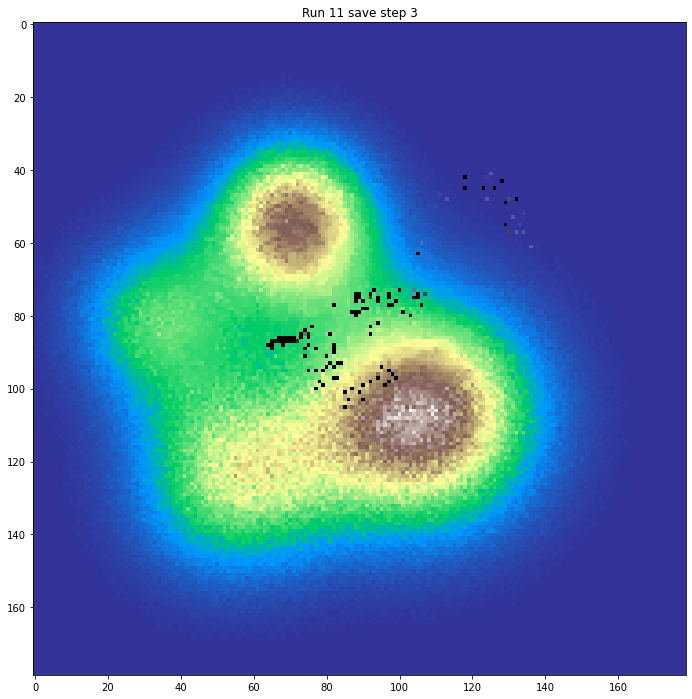

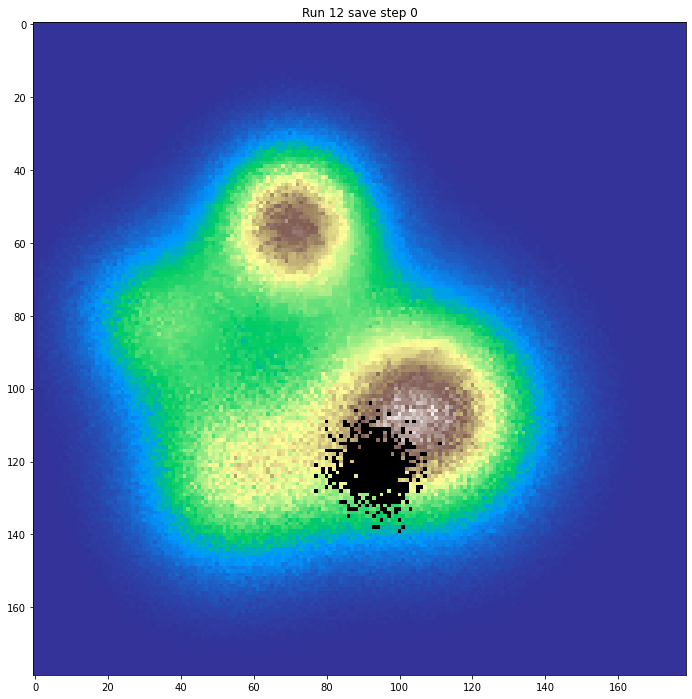

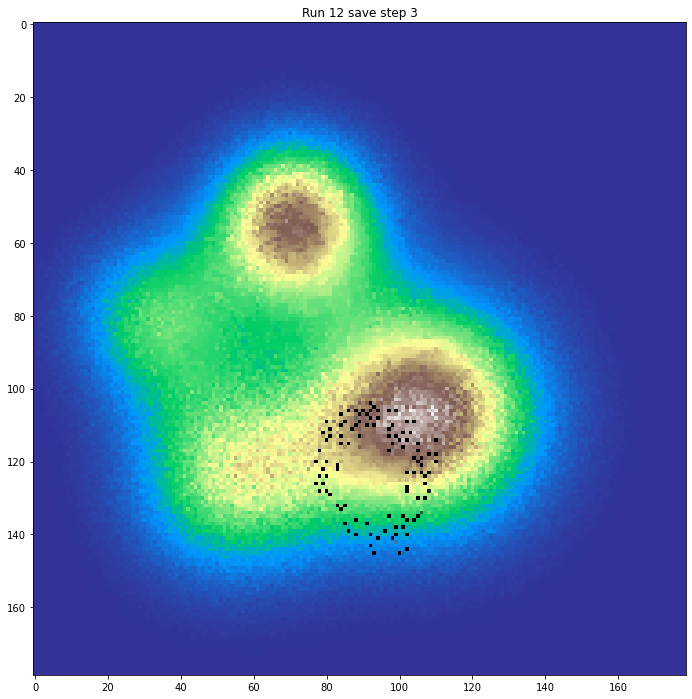

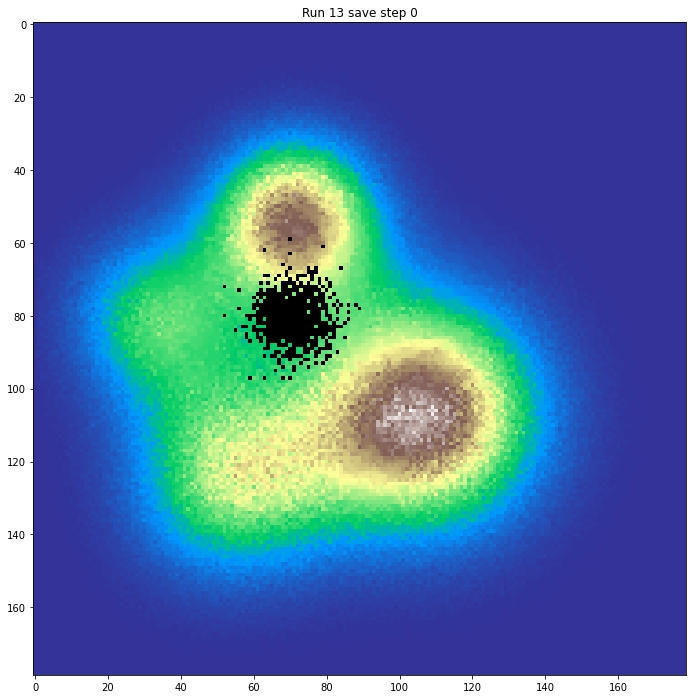

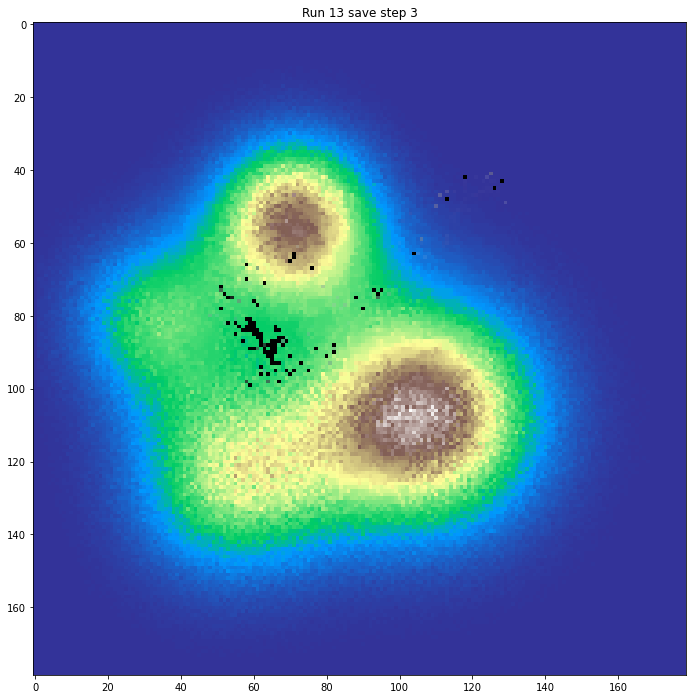

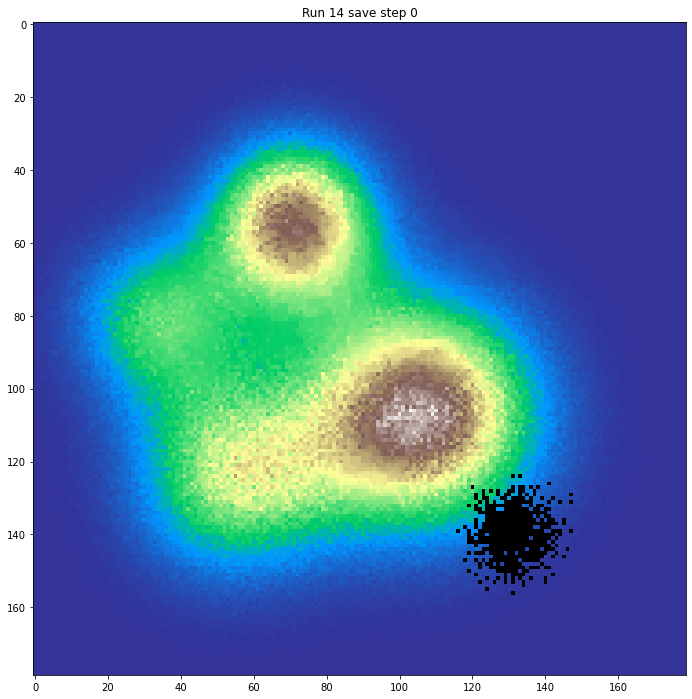

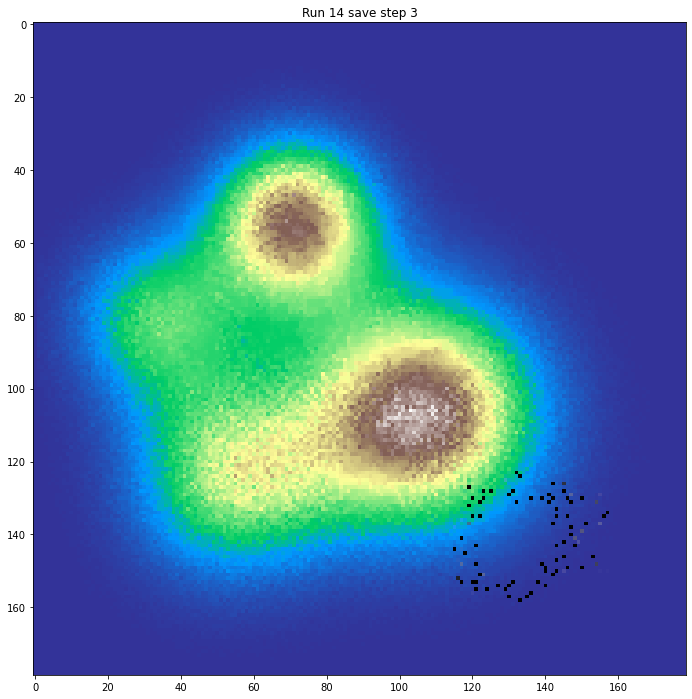

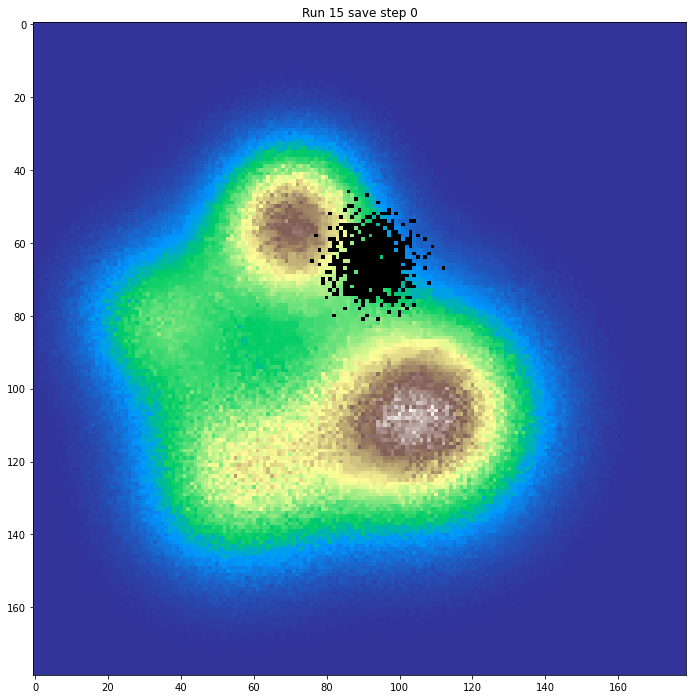

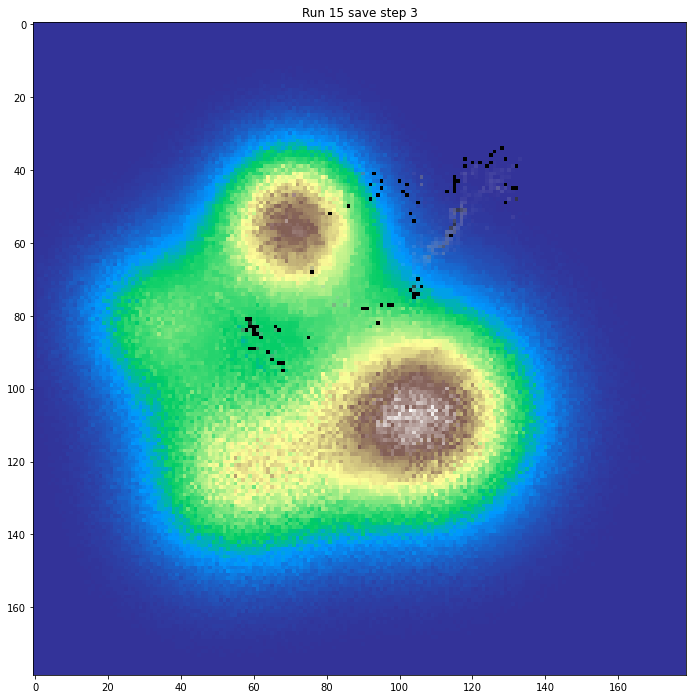

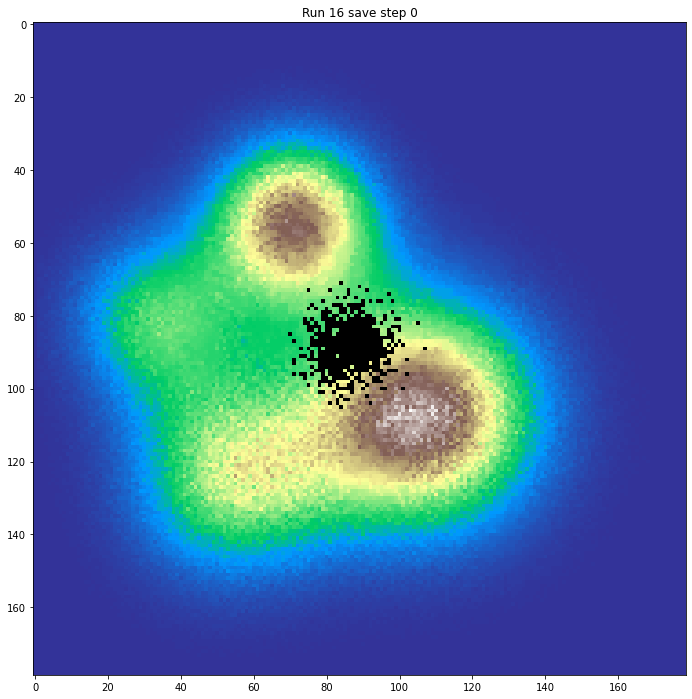

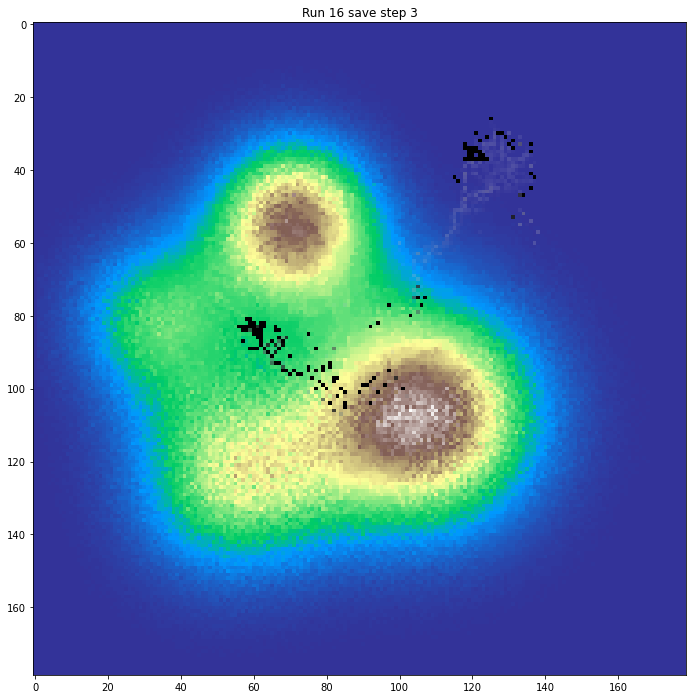

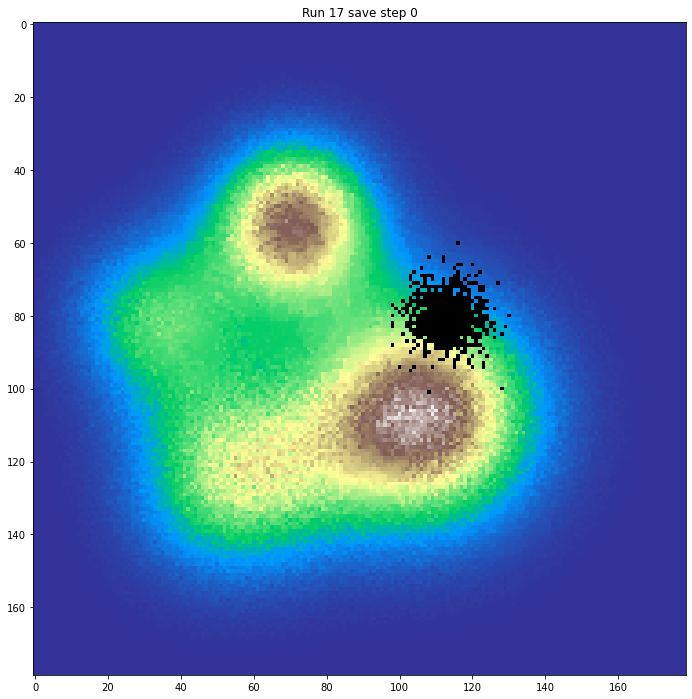

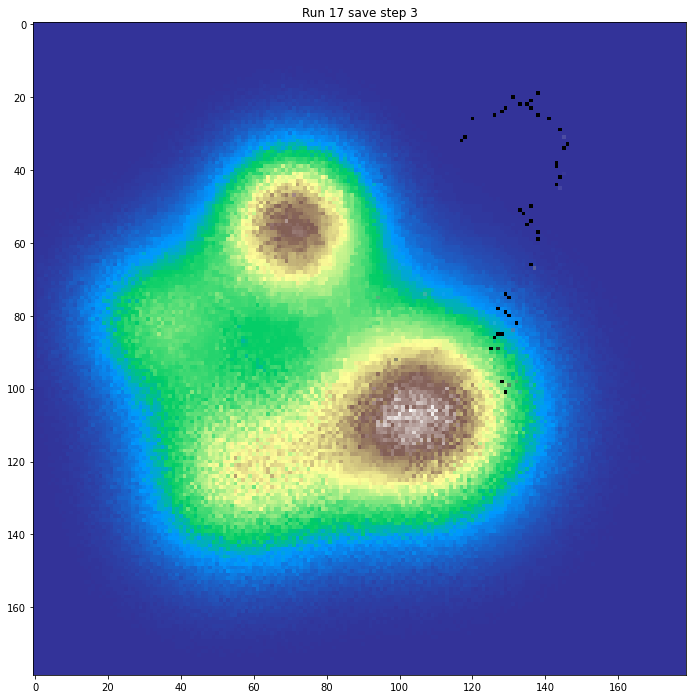

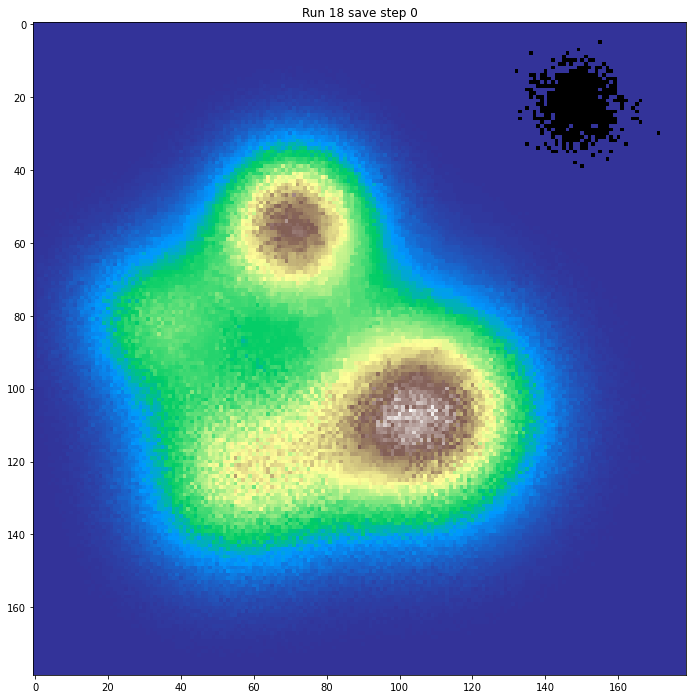

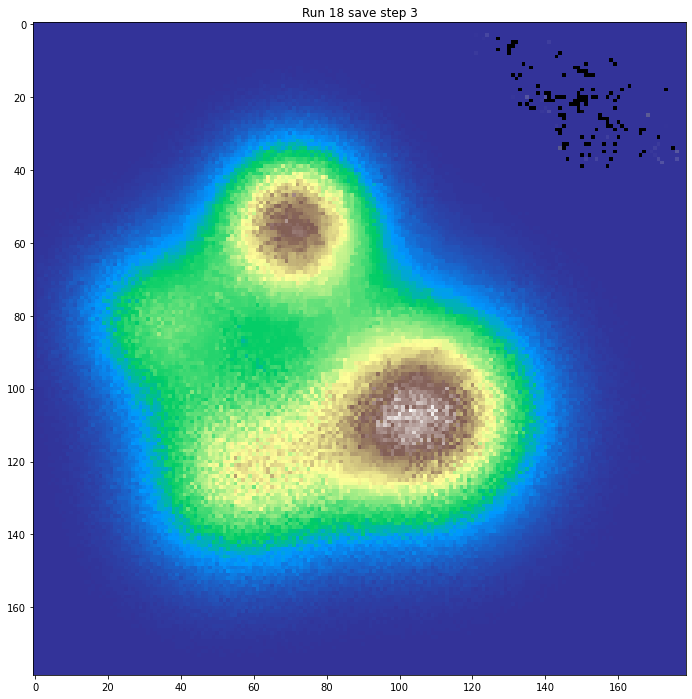

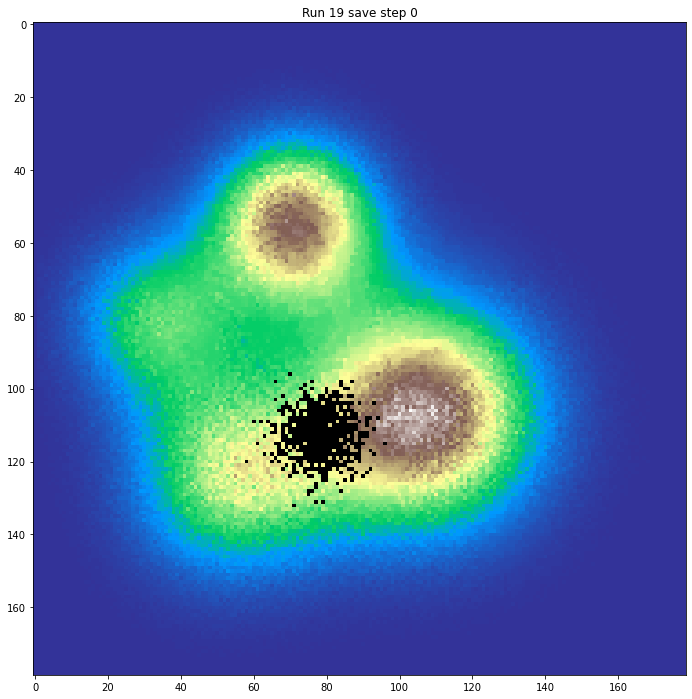

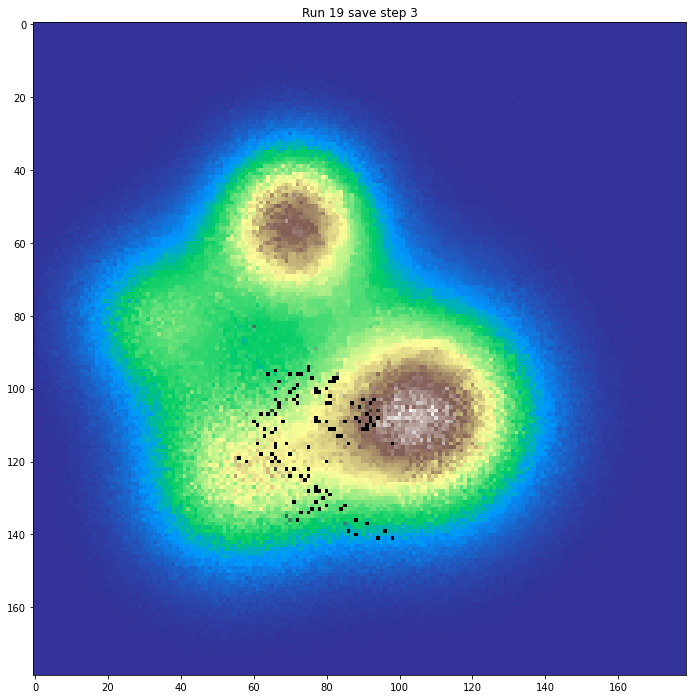

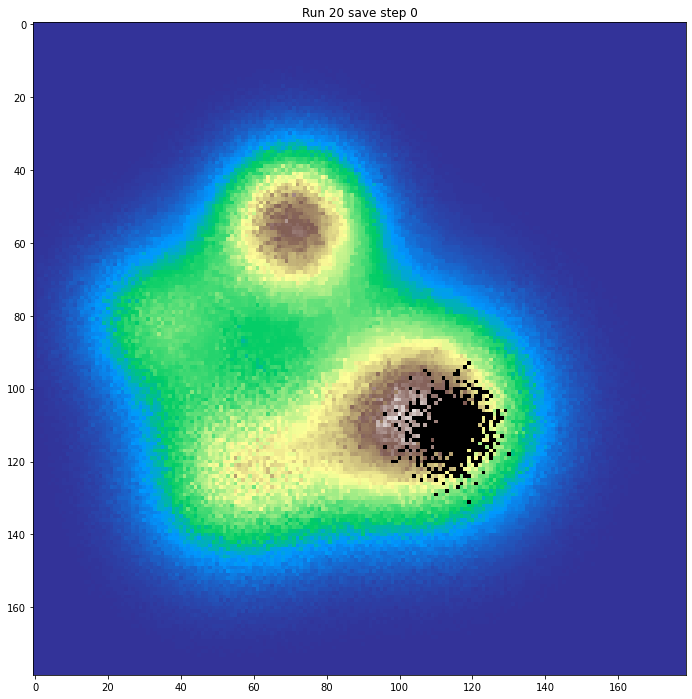

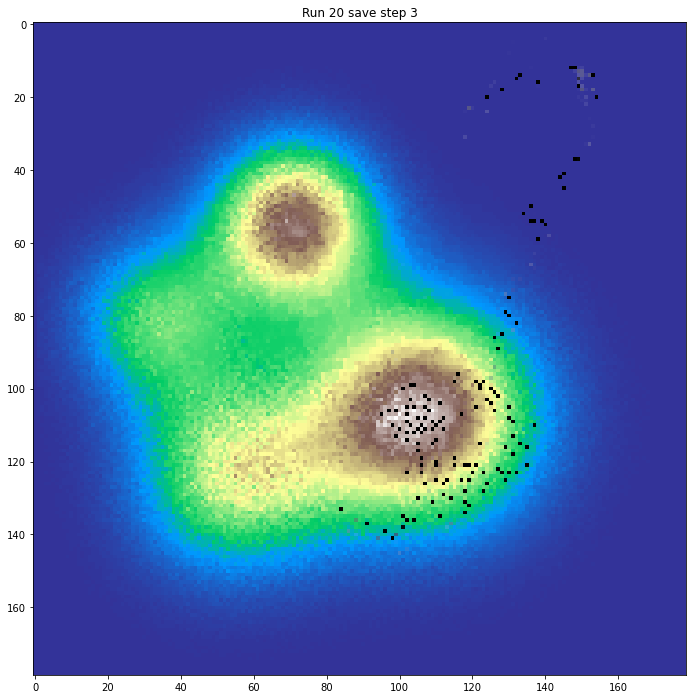

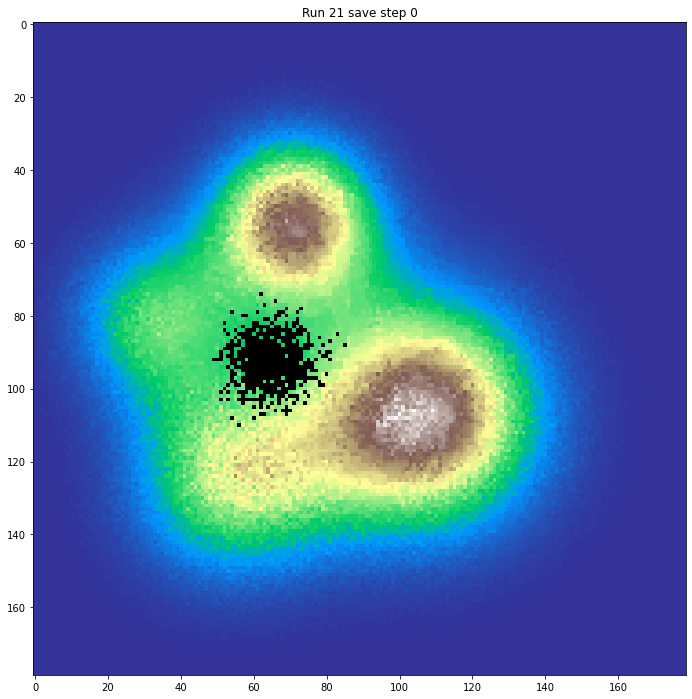

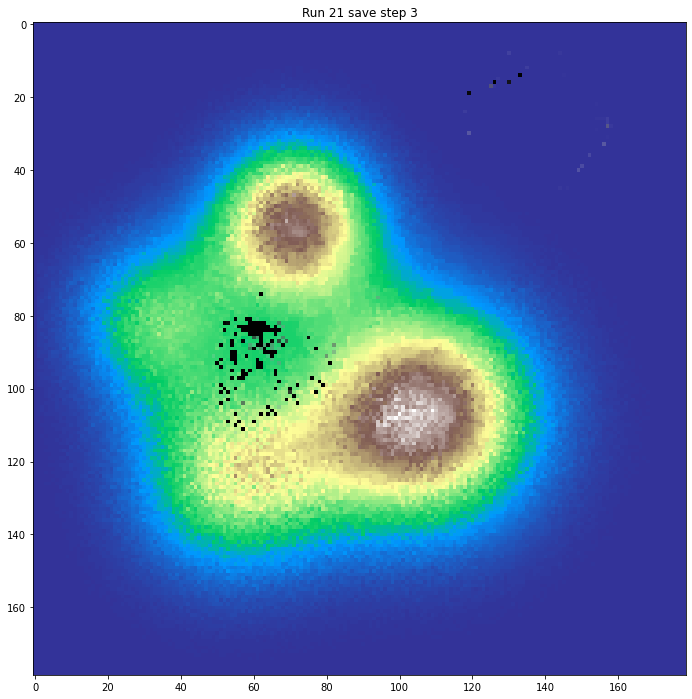

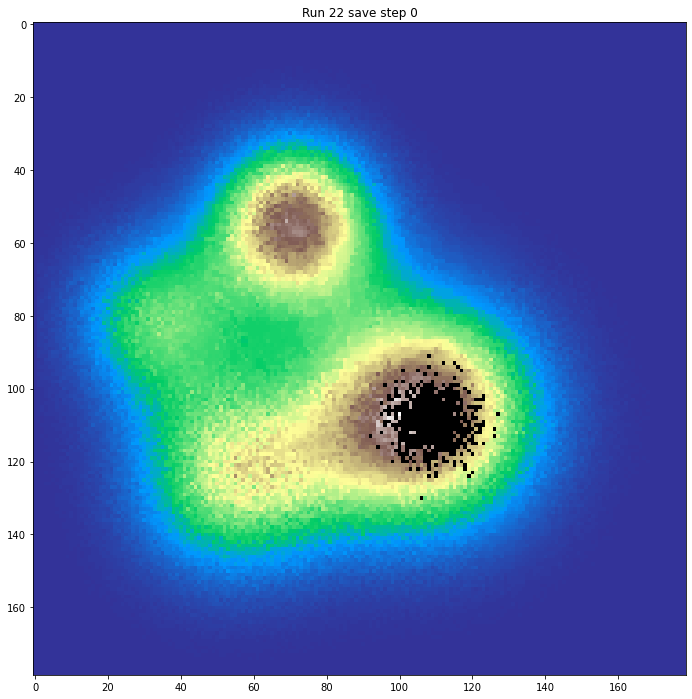

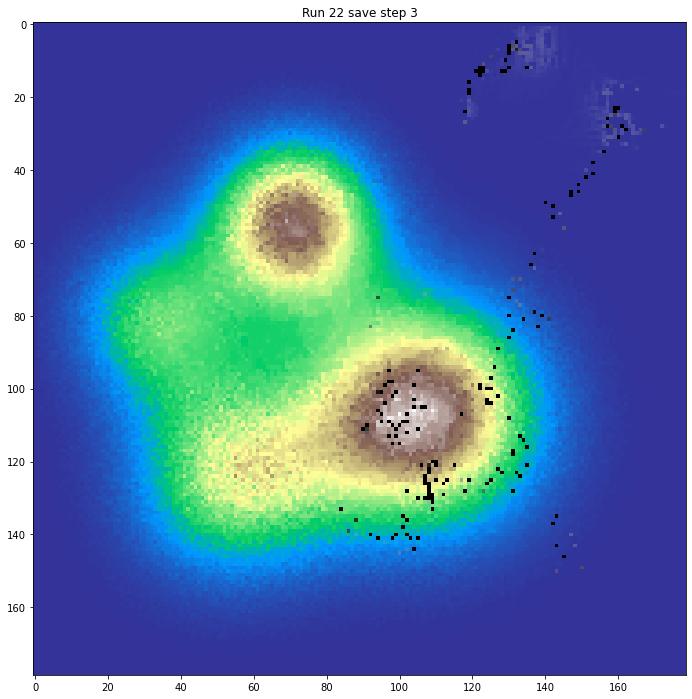

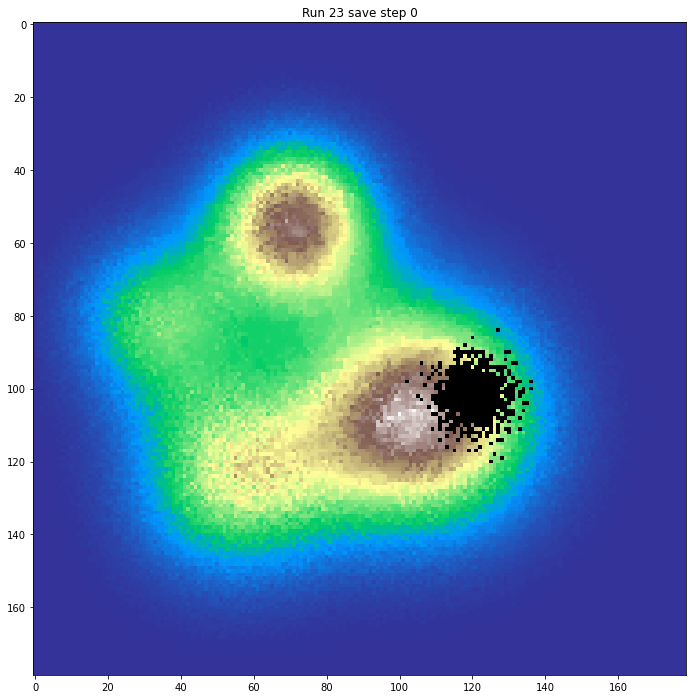

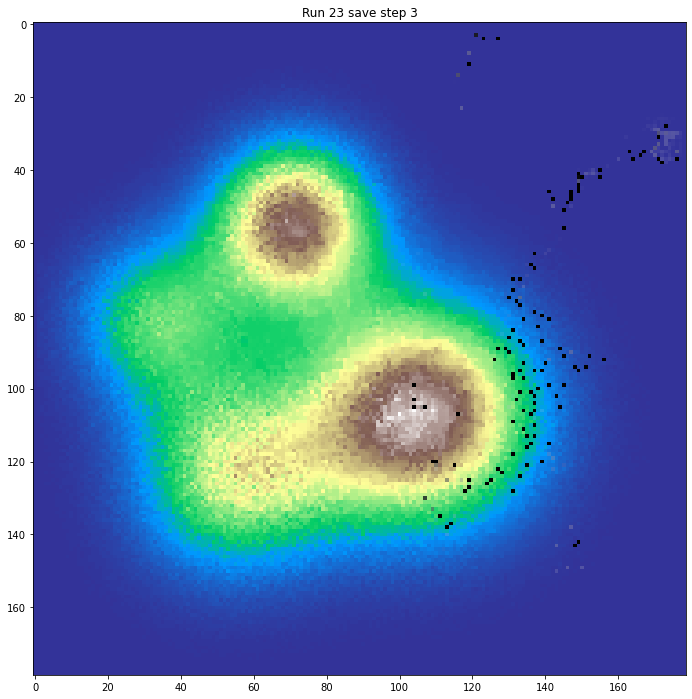

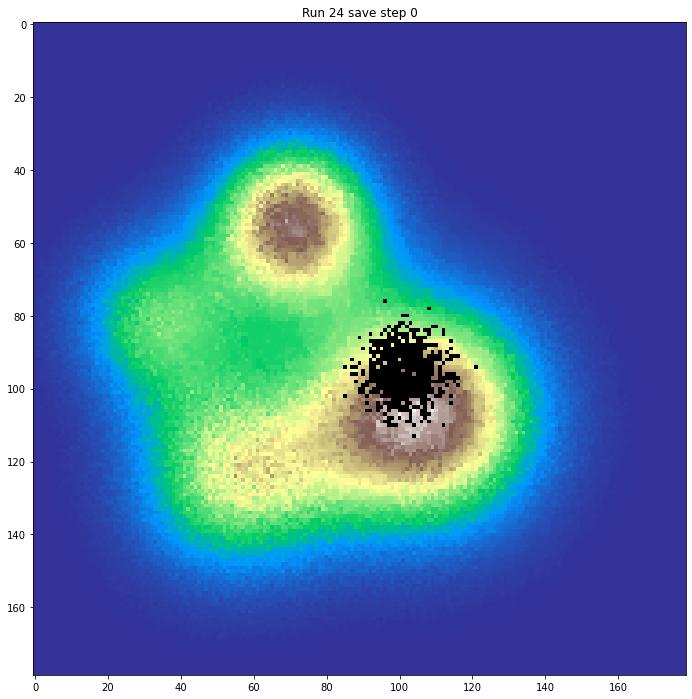

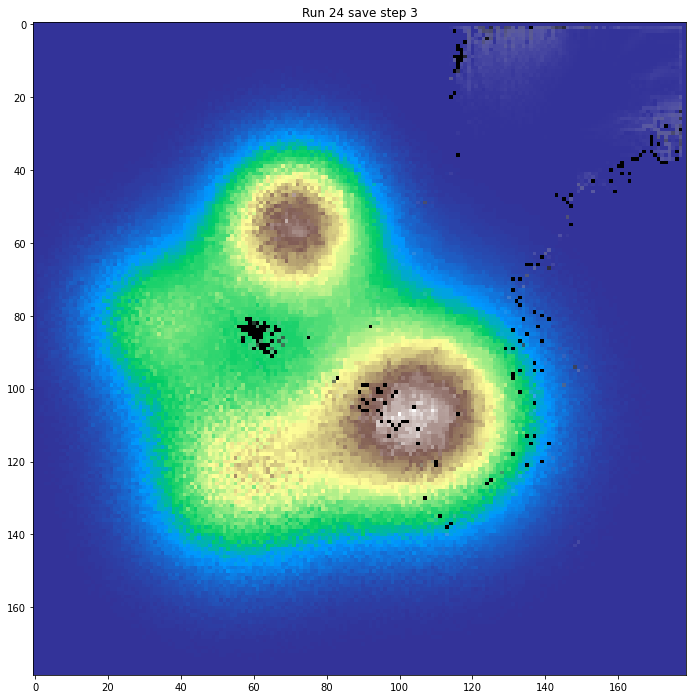

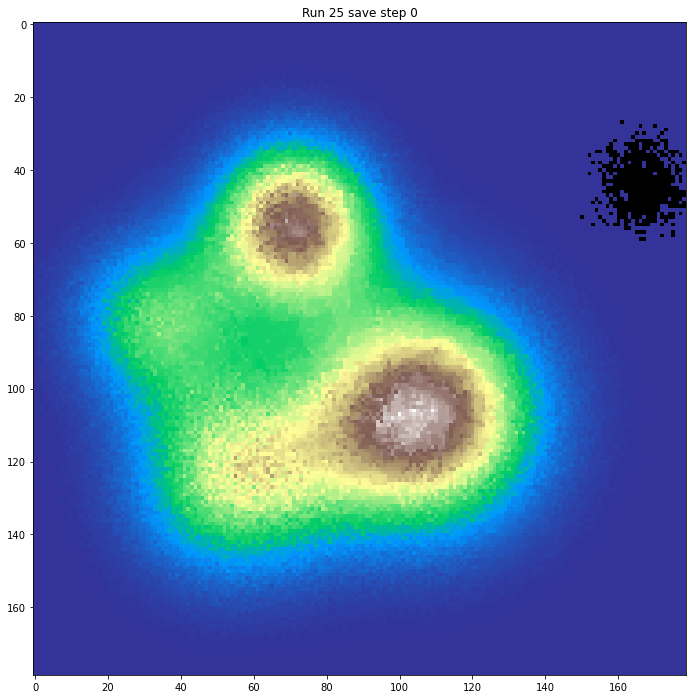

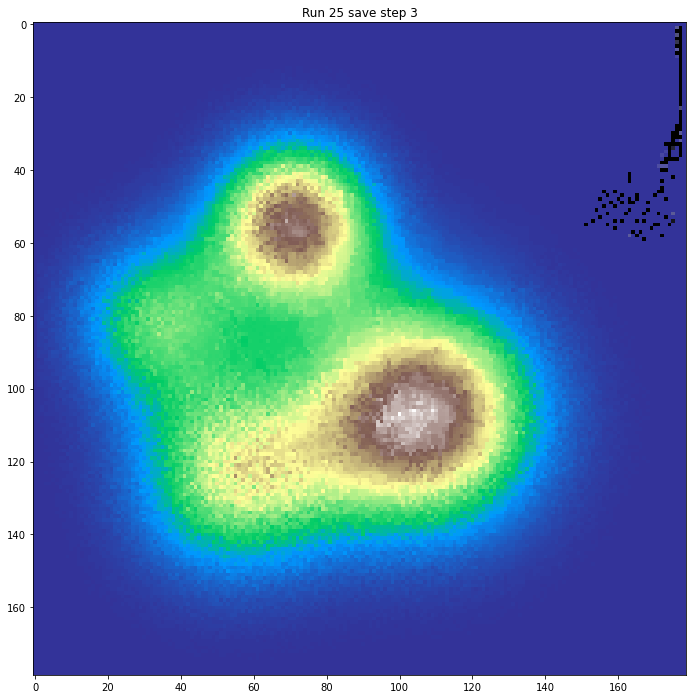

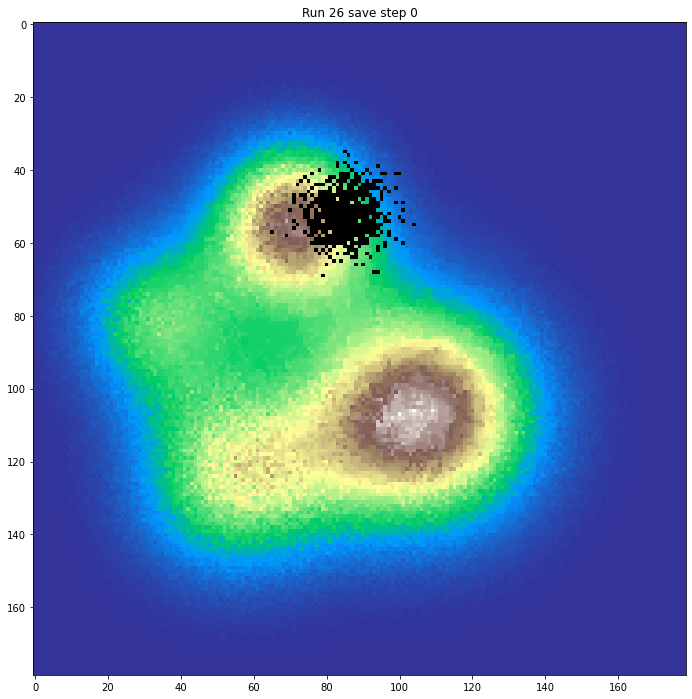

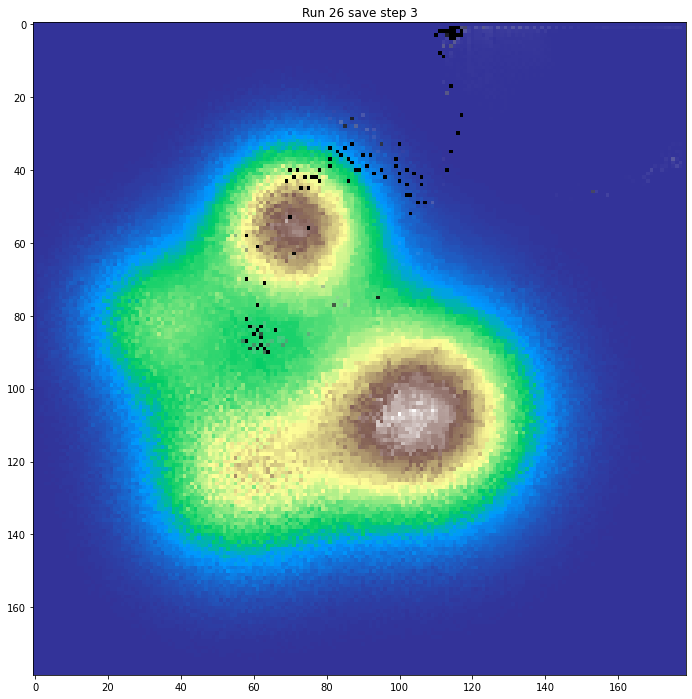

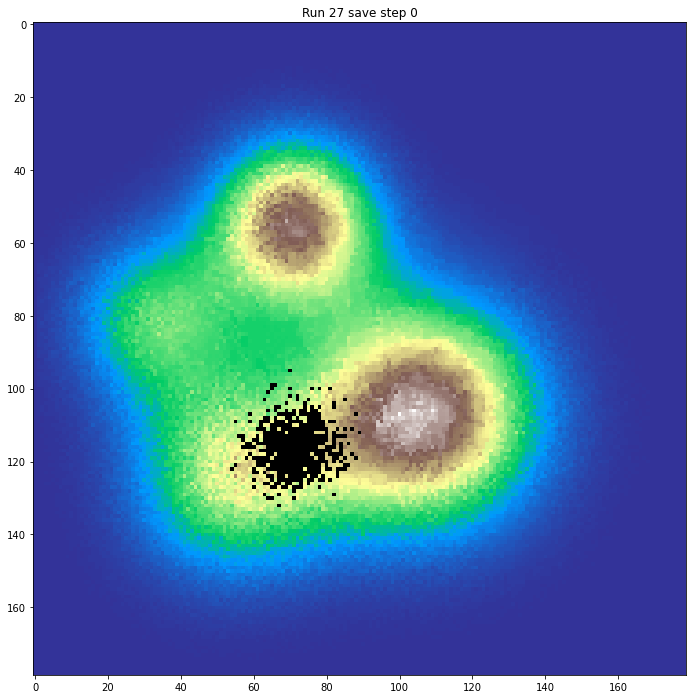

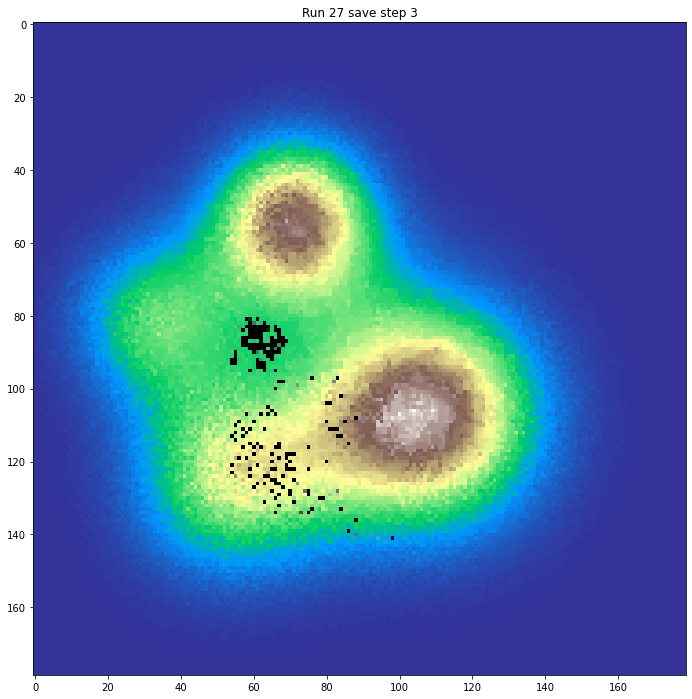

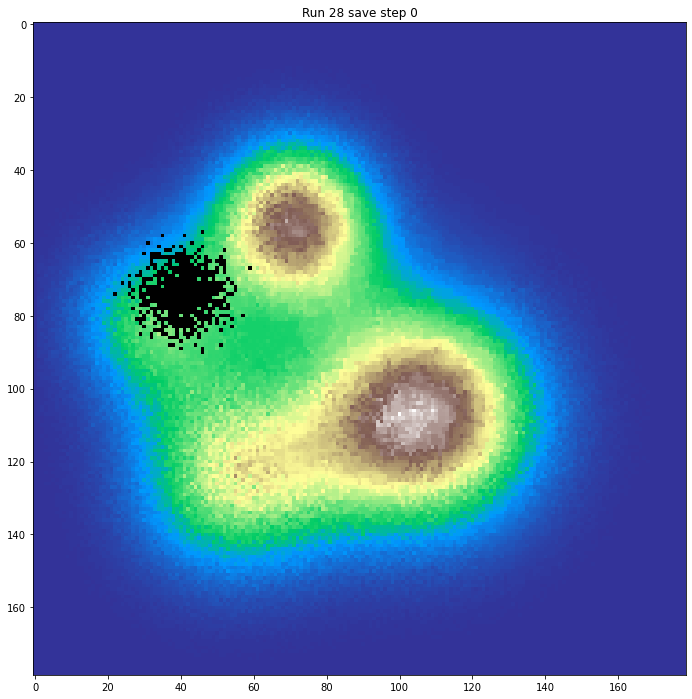

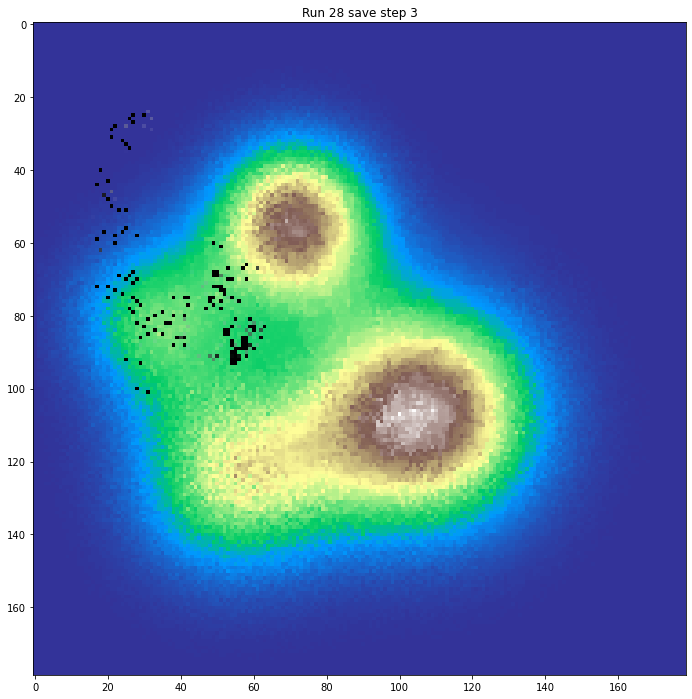

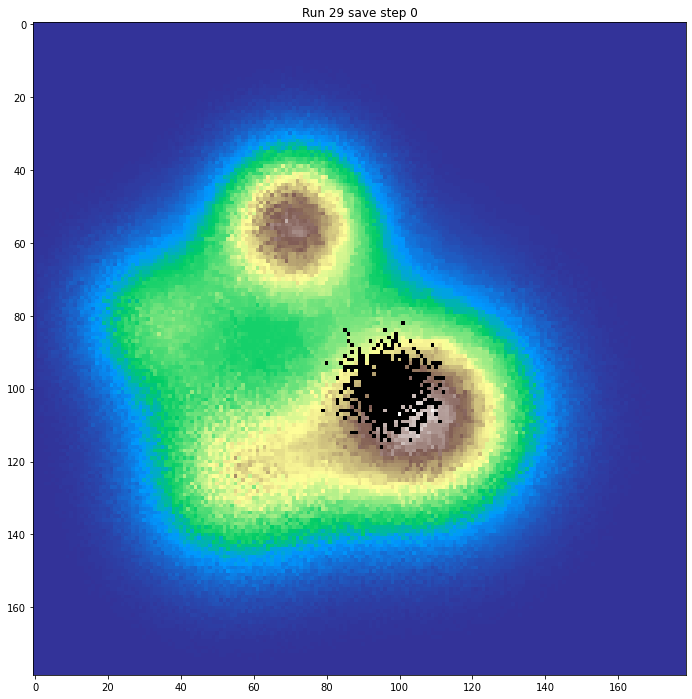

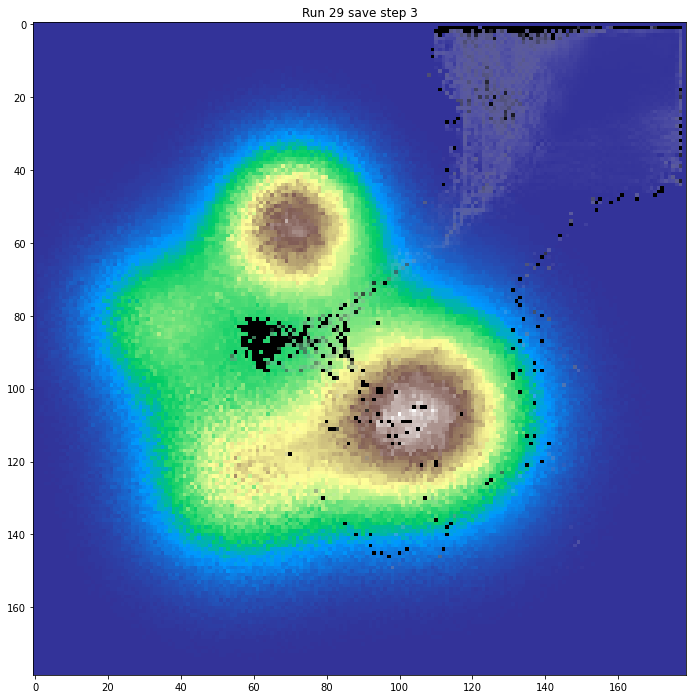

In [206]:
for j in np.arange(30):
#     for i in (0, 4):
# j = 0
#     for i in np.arange(4):
    for i in (0, 3):
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111)
        title = "Run " + str(j) + " save step " + str(i)
        ax.set_title(title)
        ax.imshow(all_gravel[j][i] + all_rock[j][i], cmap=plt.cm.terrain, )
#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
        alphas = all_waters[j][i] / 100
        alphas[alphas > 1] = 1
        ax.imshow(all_waters[j][i], cmap=plt.cm.gray_r, vmin=0, vmax=100, alpha=alphas)

NameError: name 'terrain' is not defined

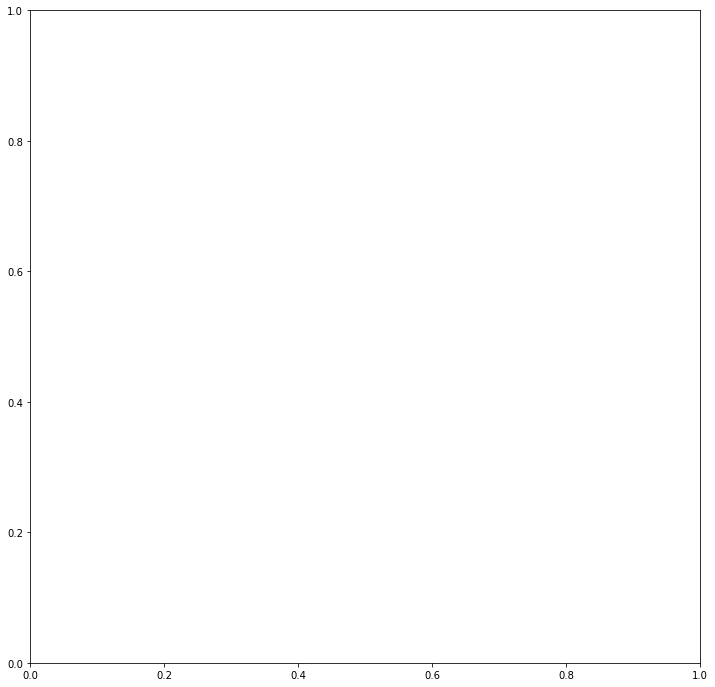

In [53]:
for i in np.arange(10):
# for i in np.ara
#     print(waters[i].max())
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    ax.imshow(terrain[i], cmap=plt.cm.terrain, )
#     alpha= (waters[i] > 0).astype(float) * 0.5
#     ax.imshow(waters[i], cmap=plt.cm.gray, vmin=0, vmax=20, alpha=0.5)
#     print(terrain[i].min(), terrain[i].max())
#     print(waters[i].min(), waters[i].max())
#     ax = fig.add_subplot(111)
#     ax.imshow(terrain[i])